Todo:

Write function that, given a reference set, finds the K (hyperparam) nearest neighbors in the 7d feature space and returns the average vote for those neighbors

Cross validate on val sets



Conditions
"Train" on domain, eval on same domain (try on each of the 4)
"Train" on n domains, eval on 1 (1 vs 1, 2 vs 1, 3 vs 1)

In [71]:
from collections import defaultdict
import csv
from itertools import islice, chain, combinations, permutations
import itertools
from functools import reduce
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Image
import scipy
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [3]:
#NOTE: Votes are counted as [fake, real], not [incorrect, correct] !

dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        if dataset_name == 'began5000' and row['realness'] == 'True': print(row)

        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [4]:
gan_models = ['progan', 'stylegan', 'began', 'wgan']

progan_votes = img_votes['progan5000']
began_votes = img_votes['began5000']
stylegan_votes = img_votes['styleganceleba5000']
wgan_votes = img_votes['wgangp5000']
votes = {k:v for k,v in chain(progan_votes.items(), stylegan_votes.items(), began_votes.items(), wgan_votes.items())}
len(votes)

In [6]:
progan_filenames = torch.load('progan_filenames.pt', map_location=torch.device('cpu'))
progan_filenames = [os.path.split(x)[-1] for x in progan_filenames]
progan_distance_features = torch.load('progan_distance_features.pt', map_location=torch.device('cpu'))

stylegan_filenames = torch.load('stylegan_filenames.pt', map_location=torch.device('cpu'))
stylegan_filenames = [os.path.split(x)[-1] for x in stylegan_filenames]
stylegan_distance_features = torch.load('stylegan_distance_features.pt', map_location=torch.device('cpu'))

began_filenames = torch.load('began_filenames.pt', map_location=torch.device('cpu'))
began_filenames = [os.path.split(x)[-1] for x in began_filenames]
began_distance_features = torch.load('began_distance_features.pt', map_location=torch.device('cpu'))

wgan_filenames = torch.load('wgan_filenames.pt', map_location=torch.device('cpu'))
wgan_filenames = [os.path.split(x)[-1] for x in wgan_filenames]
wgan_distance_features = torch.load('wgan_distance_features.pt', map_location=torch.device('cpu'))

filenames = {'progan' : progan_filenames,
        'stylegan' : stylegan_filenames,
        'began' : began_filenames,
        'wgan' : wgan_filenames}

distance_features = {'progan' : progan_distance_features,
        'stylegan' : stylegan_distance_features,
        'began' : began_distance_features,
        'wgan' : wgan_distance_features}

In [7]:
with open('../progan_train_set.txt') as f:
    progan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_train_files[:5])

with open('../progan_val_set.txt') as f:
    progan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_val_files[:5])

with open('../stylegan_train_set.txt') as f:
    stylegan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_train_files[:5])

with open('../stylegan_val_set.txt') as f:
    stylegan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_val_files[:5])

with open('../began_train_set.txt') as f:
    began_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../began_val_set.txt') as f:
    began_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])

with open('../wgan_train_set.txt') as f:
    wgan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../wgan_val_set.txt') as f:
    wgan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])



with open('../progan_test_set.txt') as f:
    progan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../stylegan_test_set.txt') as f:
    stylegan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../began_test_set.txt') as f:
    began_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../wgan_test_set.txt') as f:
    wgan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

train_files = {'progan' : progan_train_files,
        'stylegan' : stylegan_train_files,
        'began' : began_train_files,
        'wgan' : wgan_train_files}

val_files = {'progan' : progan_val_files,
        'stylegan' : stylegan_val_files,
        'began' : began_val_files,
        'wgan' : wgan_val_files}

test_files = {'progan' : progan_test_files,
        'stylegan' : stylegan_test_files,
        'began' : began_test_files,
        'wgan' : wgan_test_files}

In [8]:
progan_features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
print(len(progan_features_by_file))

stylegan_features_by_file = {stylegan_filenames[i] : stylegan_distance_features[i] for i in range(len(stylegan_filenames))}
print(len(stylegan_features_by_file))

began_features_by_file = {began_filenames[i] : began_distance_features[i] for i in range(len(began_filenames))}
print(len(began_features_by_file))

wgan_features_by_file = {wgan_filenames[i] : wgan_distance_features[i] for i in range(len(wgan_filenames))}
print(len(wgan_features_by_file))

# features_by_file = {'progan' : progan_features_by_file,
#         'stylegan' : stylegan_features_by_file,
#         'began' : began_features_by_file,
#         'wgan' : wgan_features_by_file}

features_by_file = {k:v for k,v in chain(progan_features_by_file.items(), stylegan_features_by_file.items(), 
                    began_features_by_file.items(), wgan_features_by_file.items())}

print(len(features_by_file))

2233
3103
1966
4251
11553


In [9]:
# progan_train_feats = np.array([features_by_file[x] for x in progan_train_files])
# print(progan_train_feats.shape)

# stylegan_train_feats = np.array([features_by_file[x] for x in stylegan_train_files])
# print(stylegan_train_feats.shape)

# began_train_feats = np.array([features_by_file[x] for x in began_train_files])
# print(began_train_feats.shape)

# wgan_train_feats = np.array([features_by_file[x] for x in wgan_train_files])
# print(wgan_train_feats.shape)

# train_feats = {'progan' : progan_train_feats,
#         'stylegan' : stylegan_train_feats,
#         'began' : began_train_feats,
#         'wgan' : wgan_train_feats}

In [10]:
dense_labels = {}
#dense_labels['val'] = {}
#dense_labels['test'] = {}

for m in gan_models:
    for val_or_test in ('val', 'test'):
        with open('../dense_labels/{}_{}_dense_labels.csv'.format(m, val_or_test)) as f:
            reader = csv.reader(f)
            for row in islice(reader,None):
                dense_labels[row[0]] = round(float(row[1]))
                #print(row[0], float(row[1]))

len(dense_labels)

1592

In [10]:
#progan_val_files_dense = [f for f in progan_val_files if f in dense_labels]

In [62]:

#K = 1

#model = 'progan' #Val set from same model(s)

def knn_classify(ref_feats, x_feats, votes_by_index, k_num):
    dists = np.linalg.norm(x_feats - ref_feats, axis=1)
    
    kNN = sorted(enumerate(dists), key = lambda x: x[1])[:k_num]
    kNN_votes = reduce(lambda x, y: [x[0] + y[0], x[1] + y[1]], 
                       [votes_by_index[z[0]] for z in kNN])
    
    fake_votes, real_votes = kNN_votes
    return real_votes / (real_votes + fake_votes) # Guess of chance of "real" label
    #return real_votes >= fake_votes # Tie break by guessing "fake"


def knn_eval(train_files, eval_files, k_num):   
    eval_predictions = []

    for x in eval_files:
        if x not in dense_labels: continue #this is a hack...
        feats = features_by_file[x]

        model_votes_by_index = [votes[f] for f in train_files]
        train_features = [features_by_file[f] for f in train_files]
        pred = knn_classify(train_features, feats, model_votes_by_index, k_num)
        eval_predictions.append(pred)

    eval_dense_labels = [dense_labels[x] for x in eval_files if x in dense_labels]
    #corr_score = scipy.stats.spearmanr(eval_predictions, eval_dense_labels)
    
    #print(eval_dense_labels)
    #print(eval_predictions)
    avg_precision = sklearn.metrics.average_precision_score(eval_dense_labels, eval_predictions)
    return avg_precision

def crossval_knn(train_files, val_files, test_sets, try_range):
    avg_precisions = []
    
    for k in tqdm_notebook(try_range):
        avg_precision = knn_eval(train_files, val_files, k)
        avg_precisions.append(avg_precision)
    
    #plt.scatter(try_range, rates, label='Binary accuracy')
    plt.scatter(try_range, avg_precisions)
    plt.title('Average precision vs num nearest neighbors')
    #plt.legend()
    plt.show()
    
    best_index = np.argmax(avg_precisions)
    best_k = try_range[best_index]
    
    test_avg_precisions = []
    for test_set in test_sets:
        #print(test_set)
        test_avg_precision = knn_eval(train_files, test_set, best_k)
        test_avg_precisions.append(test_avg_precision)
    
    return best_k, test_avg_precisions

#crossval_knn(progan_train_files, progan_val_files)
#crossval_knn(progan_train_files, progan_val_files, progan_val_files, (1,5,10,25,50,100,200))
knn_eval(began_train_files, began_val_files, 1)

nan

In [55]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return [x for x in chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))]

def general_sum(l):
    return reduce(lambda x,y: x+y, l)

train_combos = powerset(gan_models)
train_combos

k_vals = (1,2,3,4,5,7,10,15,20,25,30,40,50,60,80,100,125, 150, 200)
k_vals_short = (1,2,3)

In [45]:
knn_eval(began_train_files, began_val_files, 1)

nan

In [101]:
df = pd.DataFrame(lr_avg_precisions, columns=gan_models, index=train_combos)
df

progan  stylegan  began      wgan
(progan,)                        0.767017  0.796872    NaN  0.110060
(stylegan,)                      0.774967  0.787860    NaN  0.098079
(began,)                         0.691185  0.779143    NaN  0.066112
(wgan,)                          0.786391  0.779391    NaN  0.103817
(progan, stylegan)               0.769322  0.792599    NaN  0.109599
(progan, began)                  0.711364  0.730870    NaN  0.062983
(progan, wgan)                   0.649666  0.742795    NaN  0.097920
(stylegan, began)                0.698939  0.715531    NaN  0.055101
(stylegan, wgan)                 0.675619  0.751561    NaN  0.120531
(began, wgan)                    0.665795  0.748977    NaN  0.093352
(progan, stylegan, began)        0.722354  0.738917    NaN  0.075155
(progan, stylegan, wgan)         0.682829  0.758223    NaN  0.121831
(progan, began, wgan)            0.746670  0.803013    NaN  0.095671
(stylegan, began, wgan)          0.764458  0.796173    NaN  0.113318
(progan, stylegan, began, wgan)  0.758244  0.799621    NaN  0.109733

(1787, 7)
(2483, 7)
(1574, 7)
(3401, 7)
(9245, 7)


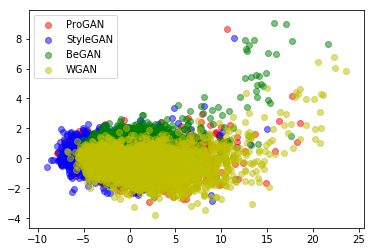

(800, 7) (847, 7) (1647, 7)


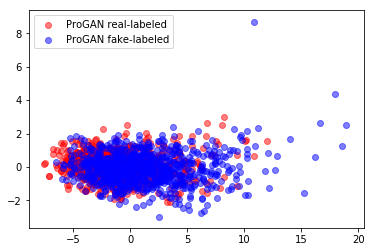

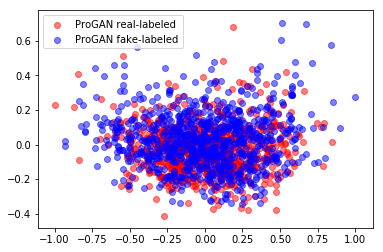

In [143]:
progan_feats = np.array([features_by_file[f] for f in progan_train_files])
print(progan_feats.shape)

stylegan_feats = np.array([features_by_file[f] for f in stylegan_train_files])
print(stylegan_feats.shape)

began_feats = np.array([features_by_file[f] for f in began_train_files])
print(began_feats.shape)

wgan_feats = np.array([features_by_file[f] for f in wgan_train_files])
print(wgan_feats.shape)

all_feats = np.concatenate((progan_feats, stylegan_feats, began_feats, wgan_feats))
print(all_feats.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pca.fit_transform(all_feats)
#transformed

plt.scatter([x[0] for x in transformed][:1787], 
            [x[1] for x in transformed][:1787], 
            color='r', label='ProGAN', alpha=0.5)

plt.scatter([x[0] for x in transformed][1787:1787+2483], 
            [x[1] for x in transformed][1787:1787+2483], 
            color='b', label='StyleGAN', alpha=0.5)

plt.scatter([x[0] for x in transformed][1787+2483:1787+2483+1574], 
            [x[1] for x in transformed][1787+2483:1787+2483+1574], 
            color='g', label='BeGAN', alpha=0.5)

plt.scatter([x[0] for x in transformed][1787+2483+1574:], 
            [x[1] for x in transformed][1787+2483+1574:], 
            color='y', label='WGAN', alpha=0.5)

plt.legend()
plt.show()


progan_pos_feats = np.array([features_by_file[f] for f in progan_train_files if votes[f][1] > votes[f][0]])
progan_neg_feats = np.array([features_by_file[f] for f in progan_train_files if votes[f][1] < votes[f][0]])
progan_both_feats = np.concatenate((progan_pos_feats, progan_neg_feats))
print(progan_pos_feats.shape, progan_neg_feats.shape, progan_both_feats.shape)

pca = PCA(n_components=2) #2-dimensional PCA
transformed = pca.fit_transform(progan_both_feats)

plt.scatter([x[0] for x in transformed][:800], 
            [x[1] for x in transformed][:800], 
            color='r', label='ProGAN real-labeled', alpha=0.5)

plt.scatter([x[0] for x in transformed][800:], 
            [x[1] for x in transformed][800:], 
            color='b', label='ProGAN fake-labeled', alpha=0.5)

plt.legend()
plt.show()



pca = PCA(n_components=4) #2-dimensional PCA
transformed = pca.fit_transform(progan_both_feats)

plt.scatter([x[2] for x in transformed][:800], 
            [x[3] for x in transformed][:800], 
            color='r', label='ProGAN real-labeled', alpha=0.5)

plt.scatter([x[2] for x in transformed][800:], 
            [x[3] for x in transformed][800:], 
            color='b', label='ProGAN fake-labeled', alpha=0.5)

plt.legend()
plt.show()

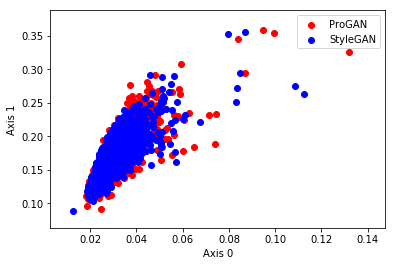

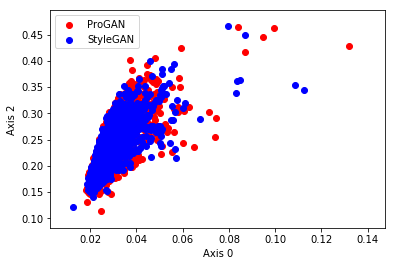

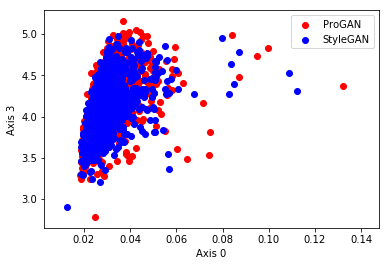

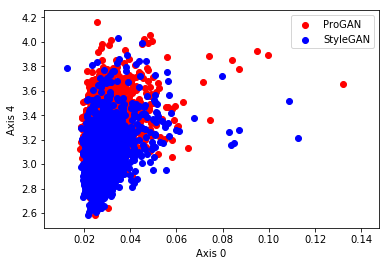

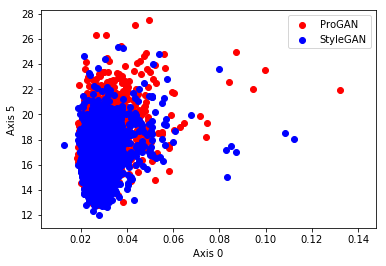

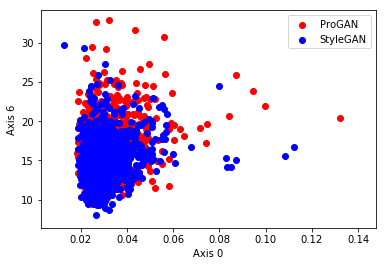

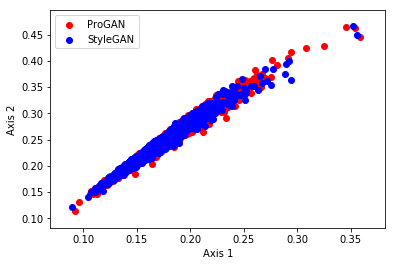

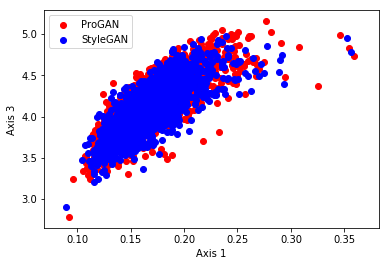

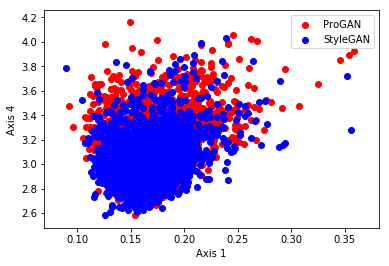

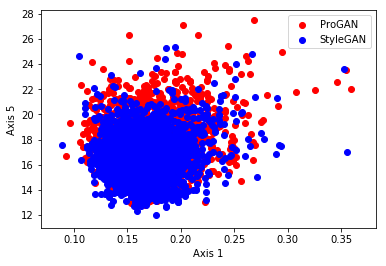

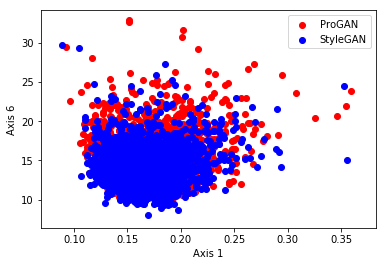

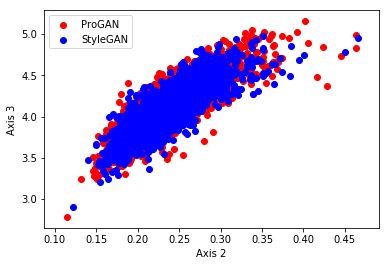

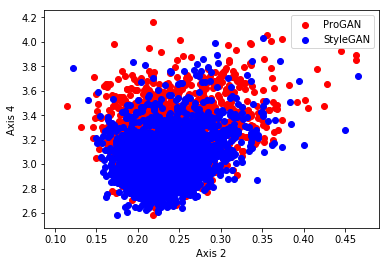

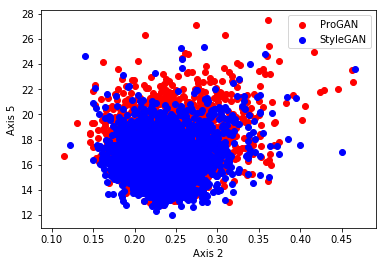

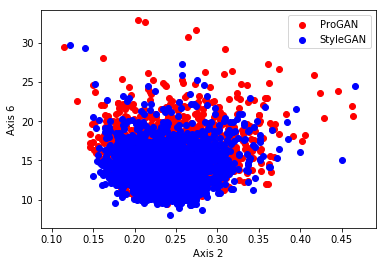

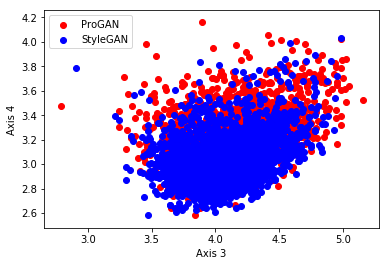

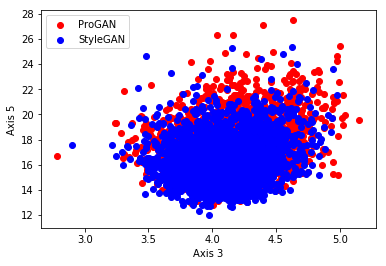

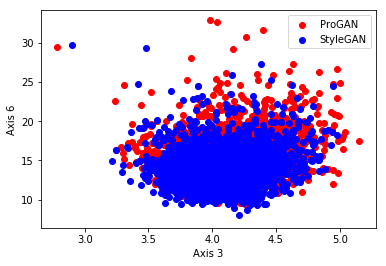

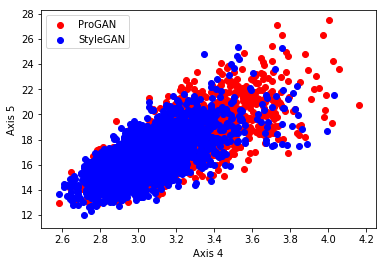

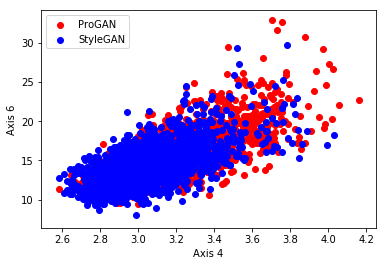

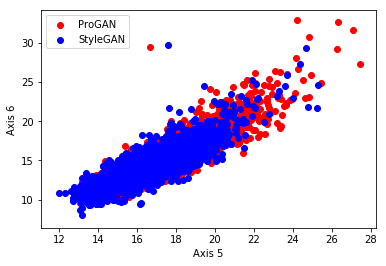

In [151]:
#N = len(progan_feats)
for axis_1 in range(7):
    for axis_2 in range(axis_1+1, 7):
        plt.xlabel('Axis {}'.format(axis_1))
        plt.ylabel('Axis {}'.format(axis_2))
        plt.scatter([x[axis_1] for x in progan_feats], [x[axis_2] for x in progan_feats], color='r', label='ProGAN')
        plt.scatter([x[axis_1] for x in stylegan_feats], [x[axis_2] for x in stylegan_feats], color='b', label='StyleGAN')
        plt.legend()
        plt.show()

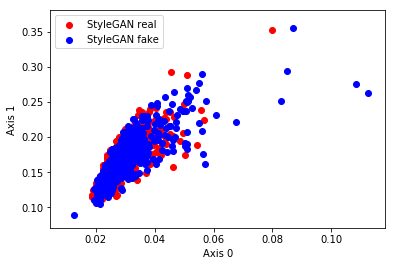

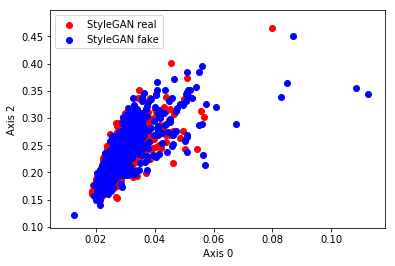

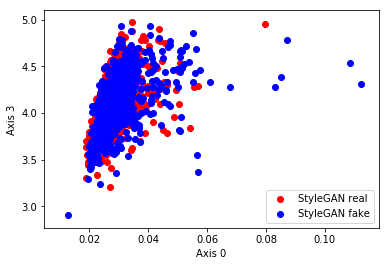

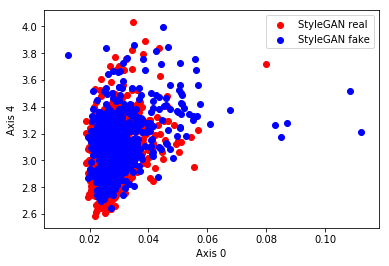

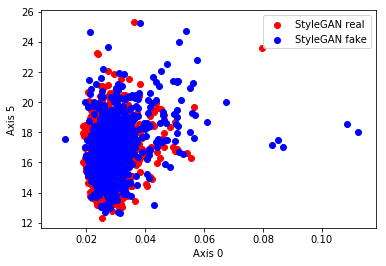

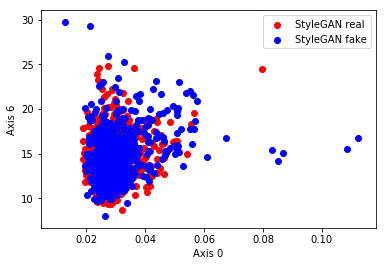

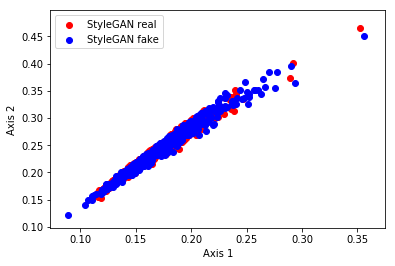

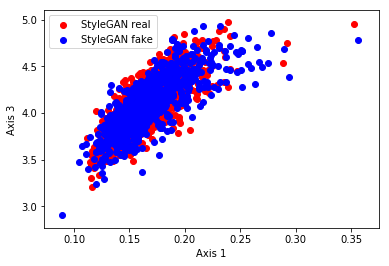

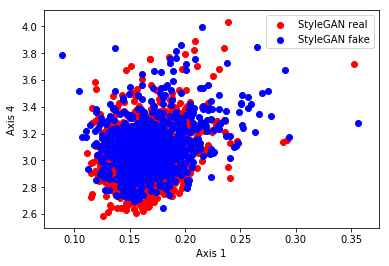

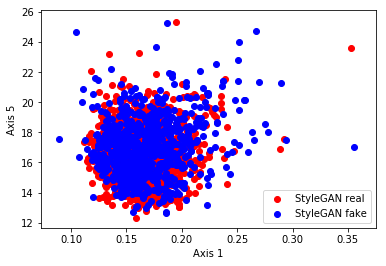

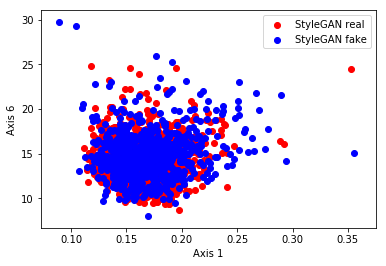

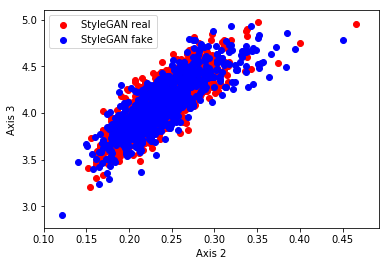

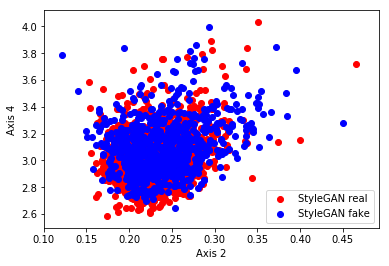

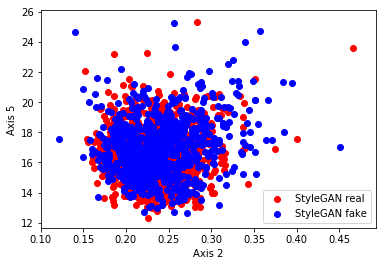

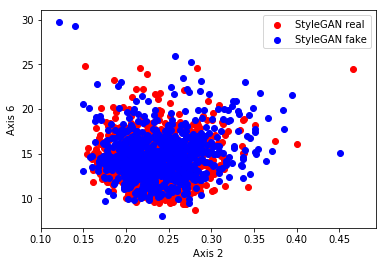

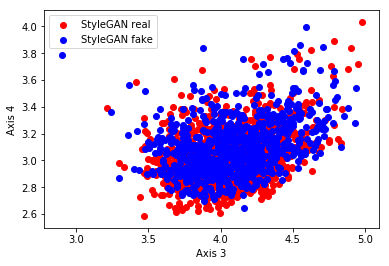

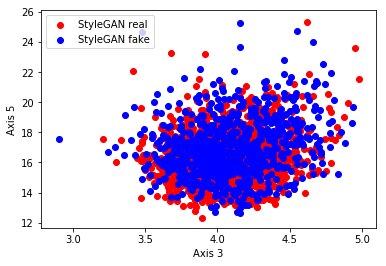

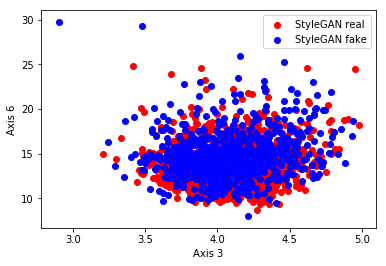

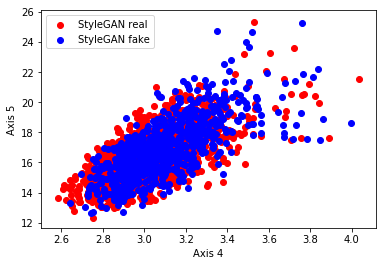

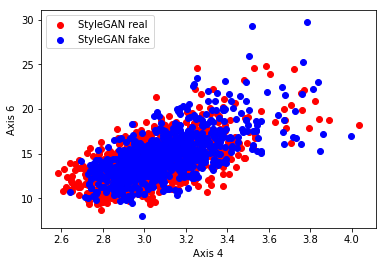

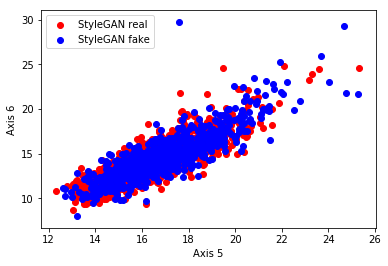

In [152]:
stylegan_pos_feats = np.array([features_by_file[f] for f in stylegan_train_files if votes[f][1] > votes[f][0]])
stylegan_neg_feats = np.array([features_by_file[f] for f in stylegan_train_files if votes[f][1] < votes[f][0]])

for axis_1 in range(7):
    for axis_2 in range(axis_1+1, 7):
        plt.xlabel('Axis {}'.format(axis_1))
        plt.ylabel('Axis {}'.format(axis_2))
        plt.scatter([x[axis_1] for x in stylegan_pos_feats], [x[axis_2] for x in stylegan_pos_feats], color='r', label='StyleGAN real')
        plt.scatter([x[axis_1] for x in stylegan_neg_feats], [x[axis_2] for x in stylegan_neg_feats], color='b', label='StyleGAN fake')
        plt.legend()
        plt.show()

(1362, 7) (798, 7) (2160, 7)


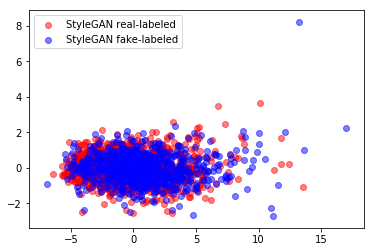

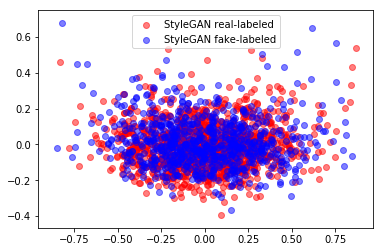

In [144]:
stylegan_pos_feats = np.array([features_by_file[f] for f in stylegan_train_files if votes[f][1] > votes[f][0]])
stylegan_neg_feats = np.array([features_by_file[f] for f in stylegan_train_files if votes[f][1] < votes[f][0]])
stylegan_both_feats = np.concatenate((stylegan_pos_feats, stylegan_neg_feats))
print(stylegan_pos_feats.shape, stylegan_neg_feats.shape, stylegan_both_feats.shape)

pca = PCA(n_components=2) #2-dimensional PCA
transformed = pca.fit_transform(stylegan_both_feats)

plt.scatter([x[0] for x in transformed][:1362], 
            [x[1] for x in transformed][:1362], 
            color='r', label='StyleGAN real-labeled', alpha=0.5)

plt.scatter([x[0] for x in transformed][1362:], 
            [x[1] for x in transformed][1362:], 
            color='b', label='StyleGAN fake-labeled', alpha=0.5)

plt.legend()
plt.show()


pca = PCA(n_components=4) #2-dimensional PCA
transformed = pca.fit_transform(stylegan_both_feats)

plt.scatter([x[2] for x in transformed][:1362], 
            [x[3] for x in transformed][:1362], 
            color='r', label='StyleGAN real-labeled', alpha=0.5)

plt.scatter([x[2] for x in transformed][1362:], 
            [x[3] for x in transformed][1362:], 
            color='b', label='StyleGAN fake-labeled', alpha=0.5)

plt.legend()
plt.show()

In [191]:
len(began_val_files), len(set(began_val_files))

(196, 196)

In [196]:
began_val_files[140], began_val_files[182]

('BEGAN_epoch44_step430000_3616.png', 'BEGAN_epoch44_step430000_737.png')

Train sets from: ('progan',)
Coefficients: [[-0.76675202 -1.75065542 -1.78564828  0.85544558 -1.38010982 -0.12423844
  -0.04824936]]

Score on train set: 0.6361333896158716
progan 0.7670172910148629
stylegan 0.796872038257278
worst ones:
BEGAN_epoch44_step430000_3616.png


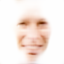

BEGAN_epoch44_step430000_3402.png


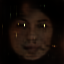

BEGAN_epoch44_step430000_772.png


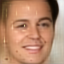

BEGAN_epoch44_step430000_3637.png


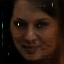

BEGAN_epoch44_step430000_1685.png


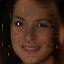

BEGAN_epoch44_step430000_2796.png


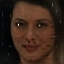

BEGAN_epoch44_step430000_1959.png


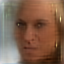

BEGAN_epoch44_step430000_164.png


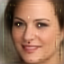

BEGAN_epoch44_step430000_2482.png


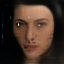

BEGAN_epoch44_step430000_2767.png


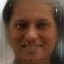

BEGAN_epoch44_step430000_2895.png


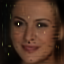

BEGAN_epoch44_step430000_2814.png


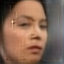

BEGAN_epoch44_step430000_3102.png


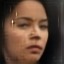

BEGAN_epoch44_step430000_3745.png


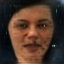

BEGAN_epoch44_step430000_3172.png


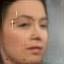



best ones:
BEGAN_epoch44_step430000_3616.png


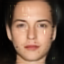

BEGAN_epoch44_step430000_737.png


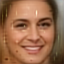

BEGAN_epoch44_step430000_2946.png


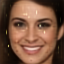

BEGAN_epoch44_step430000_3319.png


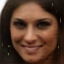

BEGAN_epoch44_step430000_161.png


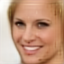

BEGAN_epoch44_step430000_2512.png


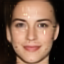

BEGAN_epoch44_step430000_1268.png


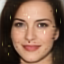

BEGAN_epoch44_step430000_2908.png


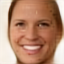

BEGAN_epoch44_step430000_2182.png


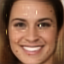

BEGAN_epoch44_step430000_1096.png


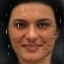

BEGAN_epoch44_step430000_22.png


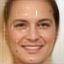

BEGAN_epoch44_step430000_1448.png


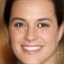

BEGAN_epoch44_step430000_3652.png


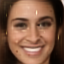

BEGAN_epoch44_step430000_1157.png


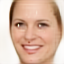

BEGAN_epoch44_step430000_2854.png


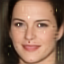

began nan
wgan 0.11006016042780749


Train sets from: ('stylegan',)
Coefficients: [[-0.94463158 -1.89150338 -2.33058517  0.70328401 -0.76047223 -0.00978159
  -0.09185312]]

Score on train set: 0.6282151208106002
progan 0.7749672538279089
stylegan 0.7878598480592629
worst ones:
BEGAN_epoch44_step430000_3402.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


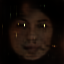

BEGAN_epoch44_step430000_3616.png


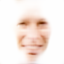

BEGAN_epoch44_step430000_772.png


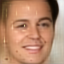

BEGAN_epoch44_step430000_1685.png


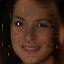

BEGAN_epoch44_step430000_3637.png


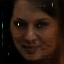

BEGAN_epoch44_step430000_1959.png


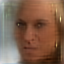

BEGAN_epoch44_step430000_2796.png


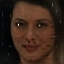

BEGAN_epoch44_step430000_164.png


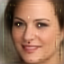

BEGAN_epoch44_step430000_2767.png


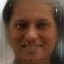

BEGAN_epoch44_step430000_2482.png


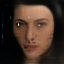

BEGAN_epoch44_step430000_2814.png


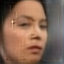

BEGAN_epoch44_step430000_3102.png


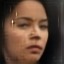

BEGAN_epoch44_step430000_2895.png


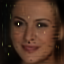

BEGAN_epoch44_step430000_1053.png


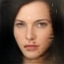

BEGAN_epoch44_step430000_1765.png


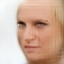



best ones:
BEGAN_epoch44_step430000_3402.png


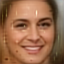

BEGAN_epoch44_step430000_2946.png


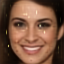

BEGAN_epoch44_step430000_3319.png


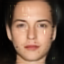

BEGAN_epoch44_step430000_737.png


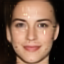

BEGAN_epoch44_step430000_1268.png


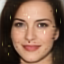

BEGAN_epoch44_step430000_2908.png


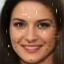

BEGAN_epoch44_step430000_1122.png


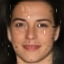

BEGAN_epoch44_step430000_1800.png


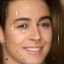

BEGAN_epoch44_step430000_2090.png


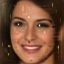

BEGAN_epoch44_step430000_1429.png


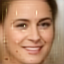

BEGAN_epoch44_step430000_988.png


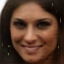

BEGAN_epoch44_step430000_161.png


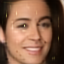

BEGAN_epoch44_step430000_1284.png


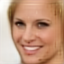

BEGAN_epoch44_step430000_2512.png


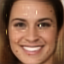

BEGAN_epoch44_step430000_1096.png


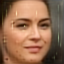

began nan
wgan 0.09807852965747701


Train sets from: ('began',)
Coefficients: [[ 0.00685451  0.1113986   0.16539082  0.02744812 -0.23436963 -0.1731952
   0.0621248 ]]

Score on train set: 0.9457943925233645
progan 0.6911853292278307
stylegan 0.7791434409294936
worst ones:
BEGAN_epoch44_step430000_2796.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


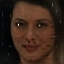

BEGAN_epoch44_step430000_3637.png


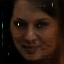

BEGAN_epoch44_step430000_2767.png


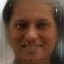

BEGAN_epoch44_step430000_2895.png


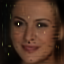

BEGAN_epoch44_step430000_1685.png


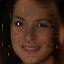

BEGAN_epoch44_step430000_772.png


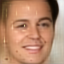

BEGAN_epoch44_step430000_2814.png


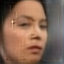

BEGAN_epoch44_step430000_3677.png


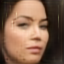

BEGAN_epoch44_step430000_164.png


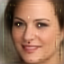

BEGAN_epoch44_step430000_3616.png


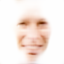

BEGAN_epoch44_step430000_2482.png


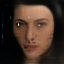

BEGAN_epoch44_step430000_4080.png


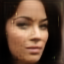

BEGAN_epoch44_step430000_3745.png


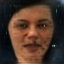

BEGAN_epoch44_step430000_1355.png


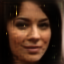

BEGAN_epoch44_step430000_2042.png


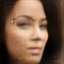



best ones:
BEGAN_epoch44_step430000_2796.png


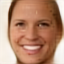

BEGAN_epoch44_step430000_2182.png


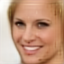

BEGAN_epoch44_step430000_2512.png


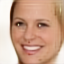

BEGAN_epoch44_step430000_530.png


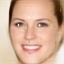

BEGAN_epoch44_step430000_2987.png


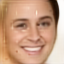

BEGAN_epoch44_step430000_2437.png


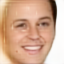

BEGAN_epoch44_step430000_479.png


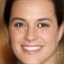

BEGAN_epoch44_step430000_3652.png


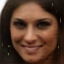

BEGAN_epoch44_step430000_161.png


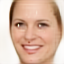

BEGAN_epoch44_step430000_2854.png


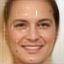

BEGAN_epoch44_step430000_1448.png


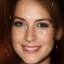

BEGAN_epoch44_step430000_1300.png


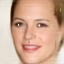

BEGAN_epoch44_step430000_293.png


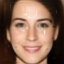

BEGAN_epoch44_step430000_4057.png


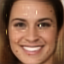

BEGAN_epoch44_step430000_1096.png


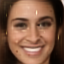

began nan
wgan 0.066112210078028


Train sets from: ('wgan',)


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Coefficients: [[-0.00471683 -0.10709322 -0.0821943   0.05460936 -0.77089836  0.02575569
  -0.18437148]]

Score on train set: 0.9859234234234234
progan 0.786391285330329
stylegan 0.7793908456925633
worst ones:
BEGAN_epoch44_step430000_3402.png


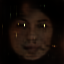

BEGAN_epoch44_step430000_3616.png


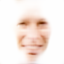

BEGAN_epoch44_step430000_772.png


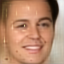

BEGAN_epoch44_step430000_1959.png


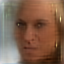

BEGAN_epoch44_step430000_1685.png


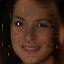

BEGAN_epoch44_step430000_3637.png


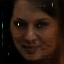

BEGAN_epoch44_step430000_2796.png


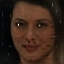

BEGAN_epoch44_step430000_2767.png


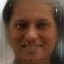

BEGAN_epoch44_step430000_164.png


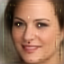

BEGAN_epoch44_step430000_2482.png


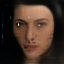

BEGAN_epoch44_step430000_1209.png


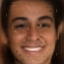

BEGAN_epoch44_step430000_2407.png


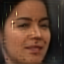

BEGAN_epoch44_step430000_3102.png


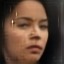

BEGAN_epoch44_step430000_2814.png


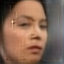

BEGAN_epoch44_step430000_2895.png


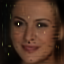



best ones:
BEGAN_epoch44_step430000_3402.png


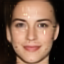

BEGAN_epoch44_step430000_1268.png


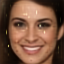

BEGAN_epoch44_step430000_3319.png


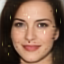

BEGAN_epoch44_step430000_2908.png


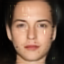

BEGAN_epoch44_step430000_737.png


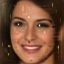

BEGAN_epoch44_step430000_1429.png


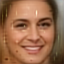

BEGAN_epoch44_step430000_2946.png


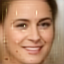

BEGAN_epoch44_step430000_988.png


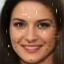

BEGAN_epoch44_step430000_1122.png


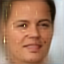

BEGAN_epoch44_step430000_2783.png


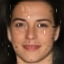

BEGAN_epoch44_step430000_1800.png


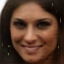

BEGAN_epoch44_step430000_161.png


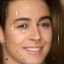

BEGAN_epoch44_step430000_2090.png


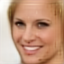

BEGAN_epoch44_step430000_2512.png


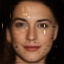

BEGAN_epoch44_step430000_933.png


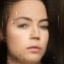

/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


began nan
wgan 0.10381652661064426


Train sets from: ('progan', 'stylegan')
Coefficients: [[-1.41395672 -2.5994824  -2.68145034  0.83144594 -1.3332333  -0.05361844
  -0.07292775]]

Score on train set: 0.6276937922161466
progan 0.7693219203311703
stylegan 0.7925993591023737
worst ones:
BEGAN_epoch44_step430000_3616.png


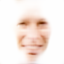

BEGAN_epoch44_step430000_3402.png


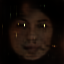

BEGAN_epoch44_step430000_772.png


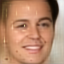

BEGAN_epoch44_step430000_1685.png


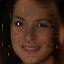

BEGAN_epoch44_step430000_3637.png


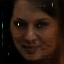

BEGAN_epoch44_step430000_1959.png


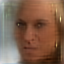

BEGAN_epoch44_step430000_2796.png


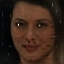

BEGAN_epoch44_step430000_164.png


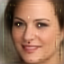

BEGAN_epoch44_step430000_2482.png


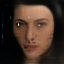

BEGAN_epoch44_step430000_2767.png


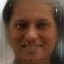

BEGAN_epoch44_step430000_2895.png


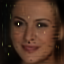

BEGAN_epoch44_step430000_2814.png


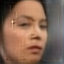

BEGAN_epoch44_step430000_3102.png


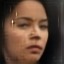

BEGAN_epoch44_step430000_3745.png


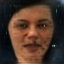

BEGAN_epoch44_step430000_1053.png


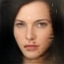



best ones:
BEGAN_epoch44_step430000_3616.png


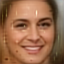

BEGAN_epoch44_step430000_2946.png


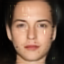

BEGAN_epoch44_step430000_737.png


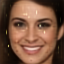

BEGAN_epoch44_step430000_3319.png


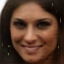

BEGAN_epoch44_step430000_161.png


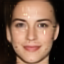

BEGAN_epoch44_step430000_1268.png


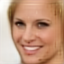

BEGAN_epoch44_step430000_2512.png


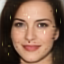

BEGAN_epoch44_step430000_2908.png


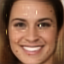

BEGAN_epoch44_step430000_1096.png


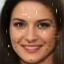

BEGAN_epoch44_step430000_1122.png


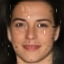

BEGAN_epoch44_step430000_1800.png


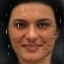

BEGAN_epoch44_step430000_22.png


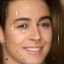

BEGAN_epoch44_step430000_2090.png


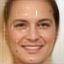

BEGAN_epoch44_step430000_1448.png


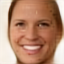

BEGAN_epoch44_step430000_2182.png


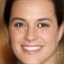

began nan
wgan 0.1095987345987346


Train sets from: ('progan', 'began')
Coefficients: [[-0.40601561  0.43085707  0.35594614  2.38748054 -1.90872441 -0.08959233
  -0.07715003]]

Score on train set: 0.759591927256598
progan 0.7113642277892305
stylegan 0.7308695768286803
worst ones:
BEGAN_epoch44_step430000_3616.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


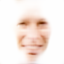

BEGAN_epoch44_step430000_3402.png


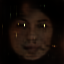

BEGAN_epoch44_step430000_772.png


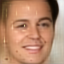

BEGAN_epoch44_step430000_3637.png


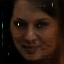

BEGAN_epoch44_step430000_1685.png


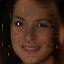

BEGAN_epoch44_step430000_164.png


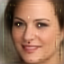

BEGAN_epoch44_step430000_2482.png


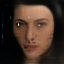

BEGAN_epoch44_step430000_1959.png


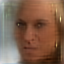

BEGAN_epoch44_step430000_2796.png


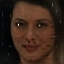

BEGAN_epoch44_step430000_1765.png


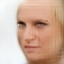

BEGAN_epoch44_step430000_1053.png


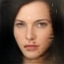

BEGAN_epoch44_step430000_2895.png


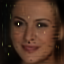

BEGAN_epoch44_step430000_2767.png


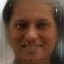

BEGAN_epoch44_step430000_2814.png


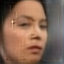

BEGAN_epoch44_step430000_974.png


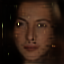



best ones:
BEGAN_epoch44_step430000_3616.png


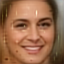

BEGAN_epoch44_step430000_2946.png


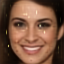

BEGAN_epoch44_step430000_3319.png


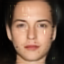

BEGAN_epoch44_step430000_737.png


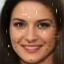

BEGAN_epoch44_step430000_1122.png


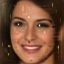

BEGAN_epoch44_step430000_1429.png


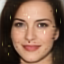

BEGAN_epoch44_step430000_2908.png


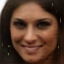

BEGAN_epoch44_step430000_161.png


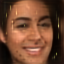

BEGAN_epoch44_step430000_3464.png


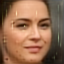

BEGAN_epoch44_step430000_3055.png


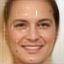

BEGAN_epoch44_step430000_1448.png


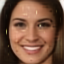

BEGAN_epoch44_step430000_3422.png


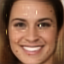

BEGAN_epoch44_step430000_1096.png


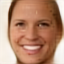

BEGAN_epoch44_step430000_2182.png


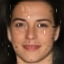

BEGAN_epoch44_step430000_1800.png


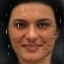

began nan
wgan 0.06298319935446545


Train sets from: ('progan', 'wgan')
Coefficients: [[-5.46152445e-01 -5.53421288e+00 -5.61886977e+00 -1.38951931e+00
   5.78796247e-01 -3.24544050e-01 -5.42055055e-03]]

Score on train set: 0.8473431206963752
progan 0.6496662696114246
stylegan 0.7427951938389554
worst ones:
BEGAN_epoch44_step430000_2767.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


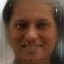

BEGAN_epoch44_step430000_772.png


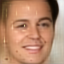

BEGAN_epoch44_step430000_2796.png


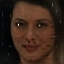

BEGAN_epoch44_step430000_3512.png


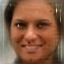

BEGAN_epoch44_step430000_1685.png


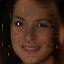

BEGAN_epoch44_step430000_3637.png


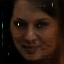

BEGAN_epoch44_step430000_1720.png


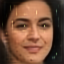

BEGAN_epoch44_step430000_3542.png


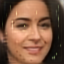

BEGAN_epoch44_step430000_2407.png


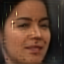

BEGAN_epoch44_step430000_2814.png


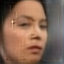

BEGAN_epoch44_step430000_3745.png


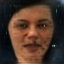

BEGAN_epoch44_step430000_1595.png


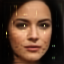

BEGAN_epoch44_step430000_2895.png


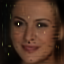

BEGAN_epoch44_step430000_1122.png


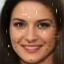

BEGAN_epoch44_step430000_1959.png


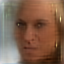



best ones:
BEGAN_epoch44_step430000_2767.png


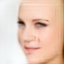

BEGAN_epoch44_step430000_502.png


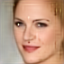

BEGAN_epoch44_step430000_3915.png


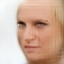

BEGAN_epoch44_step430000_1765.png


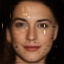

BEGAN_epoch44_step430000_933.png


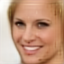

BEGAN_epoch44_step430000_2512.png


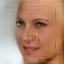

BEGAN_epoch44_step430000_3299.png


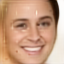

BEGAN_epoch44_step430000_2437.png


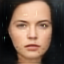

BEGAN_epoch44_step430000_2972.png


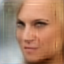

BEGAN_epoch44_step430000_1852.png


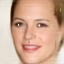

BEGAN_epoch44_step430000_293.png


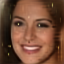

BEGAN_epoch44_step430000_134.png


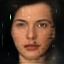

BEGAN_epoch44_step430000_41.png


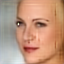

BEGAN_epoch44_step430000_1981.png


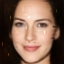

BEGAN_epoch44_step430000_3583.png


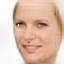

began nan
wgan 0.09792013971580535


Train sets from: ('stylegan', 'began')
Coefficients: [[-0.51974306  0.90969774  0.53636554  2.31822161 -2.16116358  0.06586309
  -0.14594112]]

Score on train set: 0.7064618467189848
progan 0.6989393186076819
stylegan 0.715530588483104
worst ones:
BEGAN_epoch44_step430000_3402.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


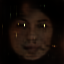

BEGAN_epoch44_step430000_3616.png


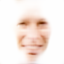

BEGAN_epoch44_step430000_772.png


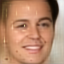

BEGAN_epoch44_step430000_3637.png


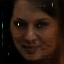

BEGAN_epoch44_step430000_1685.png


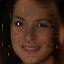

BEGAN_epoch44_step430000_1959.png


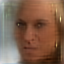

BEGAN_epoch44_step430000_164.png


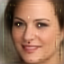

BEGAN_epoch44_step430000_2482.png


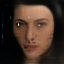

BEGAN_epoch44_step430000_1765.png


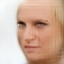

BEGAN_epoch44_step430000_2796.png


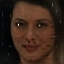

BEGAN_epoch44_step430000_1053.png


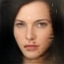

BEGAN_epoch44_step430000_3102.png


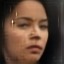

BEGAN_epoch44_step430000_2288.png


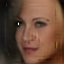

BEGAN_epoch44_step430000_974.png


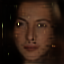

BEGAN_epoch44_step430000_2895.png


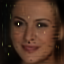



best ones:
BEGAN_epoch44_step430000_3402.png


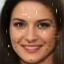

BEGAN_epoch44_step430000_1122.png


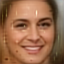

BEGAN_epoch44_step430000_2946.png


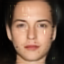

BEGAN_epoch44_step430000_737.png


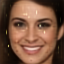

BEGAN_epoch44_step430000_3319.png


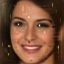

BEGAN_epoch44_step430000_1429.png


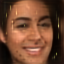

BEGAN_epoch44_step430000_3464.png


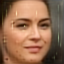

BEGAN_epoch44_step430000_3055.png


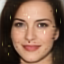

BEGAN_epoch44_step430000_2908.png


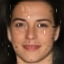

BEGAN_epoch44_step430000_1800.png


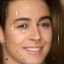

BEGAN_epoch44_step430000_2090.png


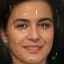

BEGAN_epoch44_step430000_2054.png


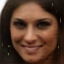

BEGAN_epoch44_step430000_161.png


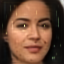

BEGAN_epoch44_step430000_1746.png


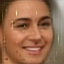

BEGAN_epoch44_step430000_2389.png


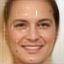

began nan
wgan 0.055101159575567


Train sets from: ('stylegan', 'wgan')
Coefficients: [[-0.11988199 -6.7589626  -6.48482984 -1.2823334  -0.26803173 -0.23768933
  -0.06372253]]

Score on train set: 0.7895826522828812
progan 0.6756189663325545
stylegan 0.7515605433725557
worst ones:
BEGAN_epoch44_step430000_772.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


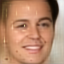

BEGAN_epoch44_step430000_1685.png


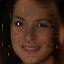

BEGAN_epoch44_step430000_2796.png


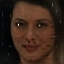

BEGAN_epoch44_step430000_2767.png


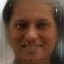

BEGAN_epoch44_step430000_3637.png


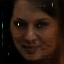

BEGAN_epoch44_step430000_3512.png


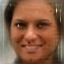

BEGAN_epoch44_step430000_1959.png


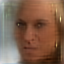

BEGAN_epoch44_step430000_2407.png


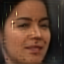

BEGAN_epoch44_step430000_3745.png


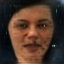

BEGAN_epoch44_step430000_1595.png


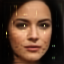

BEGAN_epoch44_step430000_1720.png


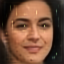

BEGAN_epoch44_step430000_2814.png


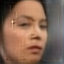

BEGAN_epoch44_step430000_2895.png


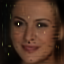

BEGAN_epoch44_step430000_3542.png


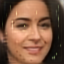

BEGAN_epoch44_step430000_3402.png


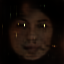



best ones:
BEGAN_epoch44_step430000_772.png


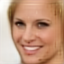

BEGAN_epoch44_step430000_2512.png


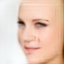

BEGAN_epoch44_step430000_502.png


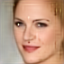

BEGAN_epoch44_step430000_3915.png


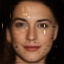

BEGAN_epoch44_step430000_933.png


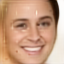

BEGAN_epoch44_step430000_2437.png


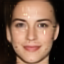

BEGAN_epoch44_step430000_1268.png


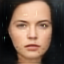

BEGAN_epoch44_step430000_2972.png


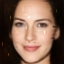

BEGAN_epoch44_step430000_3583.png


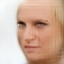

BEGAN_epoch44_step430000_1765.png


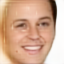

BEGAN_epoch44_step430000_479.png


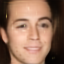

BEGAN_epoch44_step430000_2641.png


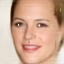

BEGAN_epoch44_step430000_293.png


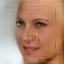

BEGAN_epoch44_step430000_3299.png


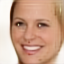

BEGAN_epoch44_step430000_530.png


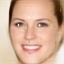

began nan
wgan 0.12053082685105157


Train sets from: ('began', 'wgan')
Coefficients: [[-0.05910572 -0.58257133 -0.67636905 -0.89248958  0.28746796 -0.13830539
  -0.0180462 ]]

Score on train set: 0.9744242099625067
progan 0.6657954310818068
stylegan 0.7489771544028593
worst ones:
BEGAN_epoch44_step430000_772.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


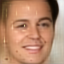

BEGAN_epoch44_step430000_2767.png


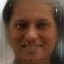

BEGAN_epoch44_step430000_2796.png


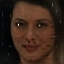

BEGAN_epoch44_step430000_1685.png


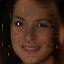

BEGAN_epoch44_step430000_3512.png


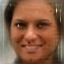

BEGAN_epoch44_step430000_3637.png


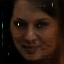

BEGAN_epoch44_step430000_1720.png


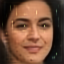

BEGAN_epoch44_step430000_2407.png


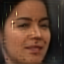

BEGAN_epoch44_step430000_3542.png


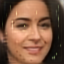

BEGAN_epoch44_step430000_1959.png


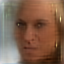

BEGAN_epoch44_step430000_2814.png


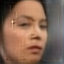

BEGAN_epoch44_step430000_2895.png


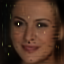

BEGAN_epoch44_step430000_3745.png


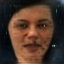

BEGAN_epoch44_step430000_1595.png


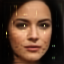

BEGAN_epoch44_step430000_4018.png


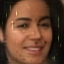



best ones:
BEGAN_epoch44_step430000_772.png


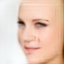

BEGAN_epoch44_step430000_502.png


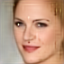

BEGAN_epoch44_step430000_3915.png


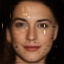

BEGAN_epoch44_step430000_933.png


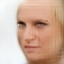

BEGAN_epoch44_step430000_1765.png


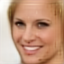

BEGAN_epoch44_step430000_2512.png


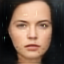

BEGAN_epoch44_step430000_2972.png


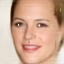

BEGAN_epoch44_step430000_293.png


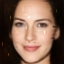

BEGAN_epoch44_step430000_3583.png


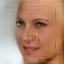

BEGAN_epoch44_step430000_3299.png


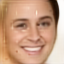

BEGAN_epoch44_step430000_2437.png


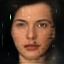

BEGAN_epoch44_step430000_41.png


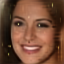

BEGAN_epoch44_step430000_134.png


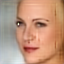

BEGAN_epoch44_step430000_1981.png


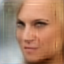

BEGAN_epoch44_step430000_1852.png


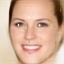

began nan
wgan 0.0933520909191217


Train sets from: ('progan', 'stylegan', 'began')
Coefficients: [[-0.99762828 -0.04357536 -0.57320627  2.05672858 -2.11547635  0.01230261
  -0.12434643]]

Score on train set: 0.6848528356066045
progan 0.722353831445772
stylegan 0.7389173523502381
worst ones:
BEGAN_epoch44_step430000_3402.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


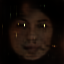

BEGAN_epoch44_step430000_3616.png


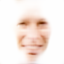

BEGAN_epoch44_step430000_772.png


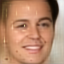

BEGAN_epoch44_step430000_3637.png


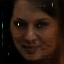

BEGAN_epoch44_step430000_1685.png


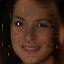

BEGAN_epoch44_step430000_1959.png


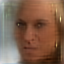

BEGAN_epoch44_step430000_164.png


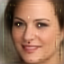

BEGAN_epoch44_step430000_2482.png


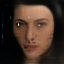

BEGAN_epoch44_step430000_2796.png


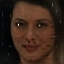

BEGAN_epoch44_step430000_1765.png


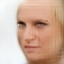

BEGAN_epoch44_step430000_1053.png


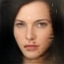

BEGAN_epoch44_step430000_3102.png


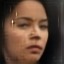

BEGAN_epoch44_step430000_2895.png


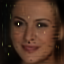

BEGAN_epoch44_step430000_2767.png


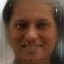

BEGAN_epoch44_step430000_2814.png


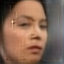



best ones:
BEGAN_epoch44_step430000_3402.png


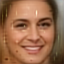

BEGAN_epoch44_step430000_2946.png


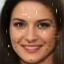

BEGAN_epoch44_step430000_1122.png


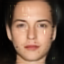

BEGAN_epoch44_step430000_737.png


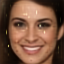

BEGAN_epoch44_step430000_3319.png


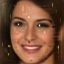

BEGAN_epoch44_step430000_1429.png


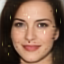

BEGAN_epoch44_step430000_2908.png


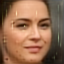

BEGAN_epoch44_step430000_3055.png


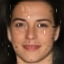

BEGAN_epoch44_step430000_1800.png


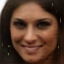

BEGAN_epoch44_step430000_161.png


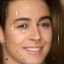

BEGAN_epoch44_step430000_2090.png


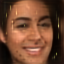

BEGAN_epoch44_step430000_3464.png


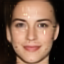

BEGAN_epoch44_step430000_1268.png


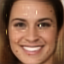

BEGAN_epoch44_step430000_1096.png


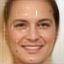

BEGAN_epoch44_step430000_1448.png


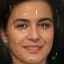

began nan
wgan 0.0751549249836921


Train sets from: ('progan', 'stylegan', 'wgan')
Coefficients: [[-0.3186074  -7.51592103 -6.29512992 -0.67301195 -0.54249482 -0.25240268
  -0.03234816]]

Score on train set: 0.7550666897626884
progan 0.6828290567859634
stylegan 0.7582231472373082
worst ones:
BEGAN_epoch44_step430000_772.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


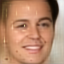

BEGAN_epoch44_step430000_1685.png


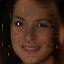

BEGAN_epoch44_step430000_3637.png


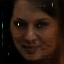

BEGAN_epoch44_step430000_2796.png


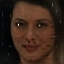

BEGAN_epoch44_step430000_2767.png


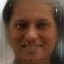

BEGAN_epoch44_step430000_3512.png


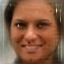

BEGAN_epoch44_step430000_1959.png


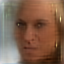

BEGAN_epoch44_step430000_2814.png


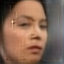

BEGAN_epoch44_step430000_3745.png


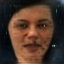

BEGAN_epoch44_step430000_2895.png


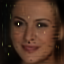

BEGAN_epoch44_step430000_3616.png


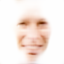

BEGAN_epoch44_step430000_2407.png


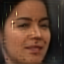

BEGAN_epoch44_step430000_1595.png


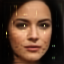

BEGAN_epoch44_step430000_3402.png


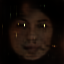

BEGAN_epoch44_step430000_1720.png


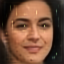



best ones:
BEGAN_epoch44_step430000_772.png


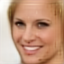

BEGAN_epoch44_step430000_2512.png


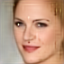

BEGAN_epoch44_step430000_3915.png


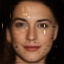

BEGAN_epoch44_step430000_933.png


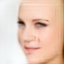

BEGAN_epoch44_step430000_502.png


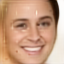

BEGAN_epoch44_step430000_2437.png


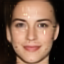

BEGAN_epoch44_step430000_1268.png


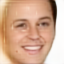

BEGAN_epoch44_step430000_479.png


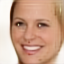

BEGAN_epoch44_step430000_530.png


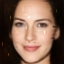

BEGAN_epoch44_step430000_3583.png


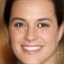

BEGAN_epoch44_step430000_3652.png


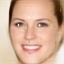

BEGAN_epoch44_step430000_2987.png


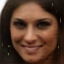

BEGAN_epoch44_step430000_161.png


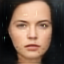

BEGAN_epoch44_step430000_2972.png


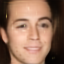

BEGAN_epoch44_step430000_2641.png


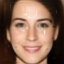

began nan
wgan 0.12183079133510168


Train sets from: ('progan', 'began', 'wgan')
Coefficients: [[-0.04004052 -3.21462347 -3.33643616  0.59543223 -0.35088485 -0.30019576
  -0.03087633]]

Score on train set: 0.861543153400427
progan 0.746670133301568
stylegan 0.8030130255991114
worst ones:
BEGAN_epoch44_step430000_772.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


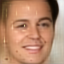

BEGAN_epoch44_step430000_3637.png


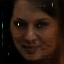

BEGAN_epoch44_step430000_3616.png


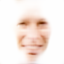

BEGAN_epoch44_step430000_1685.png


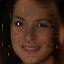

BEGAN_epoch44_step430000_3402.png


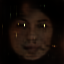

BEGAN_epoch44_step430000_2796.png


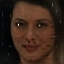

BEGAN_epoch44_step430000_2767.png


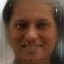

BEGAN_epoch44_step430000_1959.png


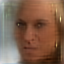

BEGAN_epoch44_step430000_2814.png


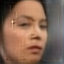

BEGAN_epoch44_step430000_2895.png


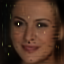

BEGAN_epoch44_step430000_164.png


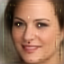

BEGAN_epoch44_step430000_2482.png


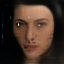

BEGAN_epoch44_step430000_3512.png


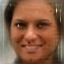

BEGAN_epoch44_step430000_3745.png


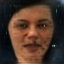

BEGAN_epoch44_step430000_2407.png


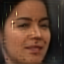



best ones:
BEGAN_epoch44_step430000_772.png


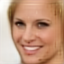

BEGAN_epoch44_step430000_2512.png


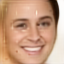

BEGAN_epoch44_step430000_2437.png


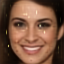

BEGAN_epoch44_step430000_3319.png


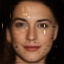

BEGAN_epoch44_step430000_933.png


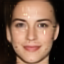

BEGAN_epoch44_step430000_1268.png


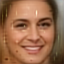

BEGAN_epoch44_step430000_2946.png


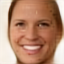

BEGAN_epoch44_step430000_2182.png


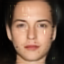

BEGAN_epoch44_step430000_737.png


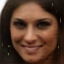

BEGAN_epoch44_step430000_161.png


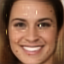

BEGAN_epoch44_step430000_1096.png


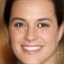

BEGAN_epoch44_step430000_3652.png


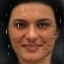

BEGAN_epoch44_step430000_22.png


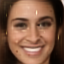

BEGAN_epoch44_step430000_1157.png


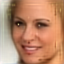

BEGAN_epoch44_step430000_1907.png


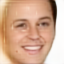

began nan
wgan 0.09567120257909731


Train sets from: ('stylegan', 'began', 'wgan')
Coefficients: [[ 0.31949132 -3.77068761 -3.7737265   0.69446821 -2.07121391 -0.15417494
  -0.1235004 ]]

Score on train set: 0.7926128832729522
progan 0.764458078470163
stylegan 0.7961733828948343
worst ones:
BEGAN_epoch44_step430000_3402.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


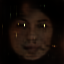

BEGAN_epoch44_step430000_3616.png


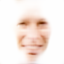

BEGAN_epoch44_step430000_772.png


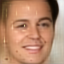

BEGAN_epoch44_step430000_1685.png


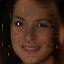

BEGAN_epoch44_step430000_3637.png


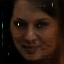

BEGAN_epoch44_step430000_2796.png


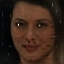

BEGAN_epoch44_step430000_1959.png


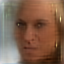

BEGAN_epoch44_step430000_2767.png


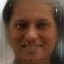

BEGAN_epoch44_step430000_164.png


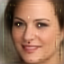

BEGAN_epoch44_step430000_2482.png


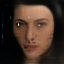

BEGAN_epoch44_step430000_2895.png


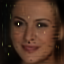

BEGAN_epoch44_step430000_2814.png


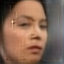

BEGAN_epoch44_step430000_3745.png


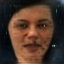

BEGAN_epoch44_step430000_3102.png


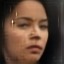

BEGAN_epoch44_step430000_2407.png


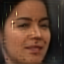



best ones:
BEGAN_epoch44_step430000_3402.png


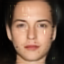

BEGAN_epoch44_step430000_737.png


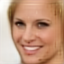

BEGAN_epoch44_step430000_2512.png


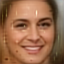

BEGAN_epoch44_step430000_2946.png


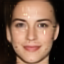

BEGAN_epoch44_step430000_1268.png


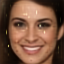

BEGAN_epoch44_step430000_3319.png


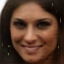

BEGAN_epoch44_step430000_161.png


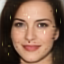

BEGAN_epoch44_step430000_2908.png


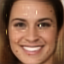

BEGAN_epoch44_step430000_1096.png


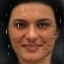

BEGAN_epoch44_step430000_22.png


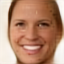

BEGAN_epoch44_step430000_2182.png


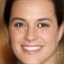

BEGAN_epoch44_step430000_3652.png


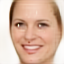

BEGAN_epoch44_step430000_2854.png


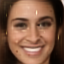

BEGAN_epoch44_step430000_1157.png


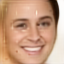

BEGAN_epoch44_step430000_2437.png


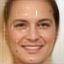

began nan
wgan 0.11331845238095237


Train sets from: ('progan', 'stylegan', 'began', 'wgan')
Coefficients: [[ 0.15154755 -4.51220659 -4.34601798  0.85054921 -1.59415679 -0.19124724
  -0.0844365 ]]

Score on train set: 0.7496711968434897
progan 0.7582442084511848
stylegan 0.7996209485599256
worst ones:
BEGAN_epoch44_step430000_3616.png


/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


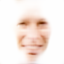

BEGAN_epoch44_step430000_3402.png


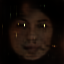

BEGAN_epoch44_step430000_772.png


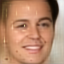

BEGAN_epoch44_step430000_1685.png


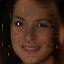

BEGAN_epoch44_step430000_3637.png


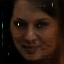

BEGAN_epoch44_step430000_2796.png


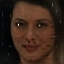

BEGAN_epoch44_step430000_1959.png


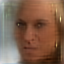

BEGAN_epoch44_step430000_2767.png


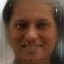

BEGAN_epoch44_step430000_164.png


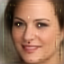

BEGAN_epoch44_step430000_2482.png


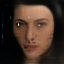

BEGAN_epoch44_step430000_2895.png


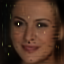

BEGAN_epoch44_step430000_2814.png


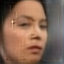

BEGAN_epoch44_step430000_3745.png


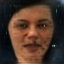

BEGAN_epoch44_step430000_3102.png


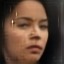

BEGAN_epoch44_step430000_2407.png


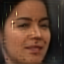



best ones:
BEGAN_epoch44_step430000_3616.png


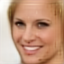

BEGAN_epoch44_step430000_2512.png


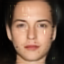

BEGAN_epoch44_step430000_737.png


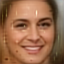

BEGAN_epoch44_step430000_2946.png


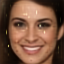

BEGAN_epoch44_step430000_3319.png


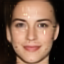

BEGAN_epoch44_step430000_1268.png


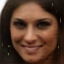

BEGAN_epoch44_step430000_161.png


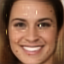

BEGAN_epoch44_step430000_1096.png


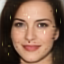

BEGAN_epoch44_step430000_2908.png


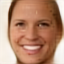

BEGAN_epoch44_step430000_2182.png


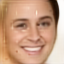

BEGAN_epoch44_step430000_2437.png


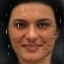

BEGAN_epoch44_step430000_22.png


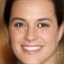

BEGAN_epoch44_step430000_3652.png


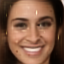

BEGAN_epoch44_step430000_1157.png


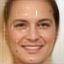

BEGAN_epoch44_step430000_1448.png


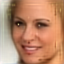

began nan
wgan 0.10973300892655731




/Users/alexkolchinski/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [200]:
lr_avg_precisions = np.zeros((len(train_combos), len(gan_models)))

for i, train_combo in enumerate(train_combos):
    print('Train sets from: {}'.format(train_combo))
    train_set = general_sum([train_files[x] for x in train_combo])
    test_sets = [val_files[eval_model] for eval_model in gan_models] #Change this to test!
    
    X_train = []
    Y_train = []
    for f in train_set:
        cur_feats = features_by_file[f]
        cur_votes = votes[f]
        fake_votes, real_votes = cur_votes

        for k in range(fake_votes):
            X_train.append(cur_feats)
            Y_train.append(0)

        for k in range(real_votes):
            X_train.append(cur_feats)
            Y_train.append(1)
    
    lr_model = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
    
    print('Coefficients: {}\n'.format(lr_model.coef_))
    print('Score on train set: {}'.format(lr_model.score(X_train, Y_train)))
    
    for j, test_set in enumerate(test_sets):
        #print(test_set)
        test_feats = [features_by_file[f] for f in test_set if f in dense_labels]
        test_labels = [dense_labels[f] for f in test_set if f in dense_labels]
        
        preds = [x[1] for x in lr_model.predict_proba(test_feats)]
        if j == 2:
            #print(len(preds))
            best_index = np.argmax(preds)
            worst_index = np.argmin(preds)
            worst_to_best = sorted(enumerate(preds), key=lambda x: x[1])
            #print(test_set[best_index], test_set[worst_index])
            #print(worst_to_best)
            print("worst ones:")
            for it in range(15):
                print(test_set[worst_to_best[it][0]])
                display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + test_set[worst_to_best[it][0]]))


            print("\n\nbest ones:")
            for it in range(15):
                print(test_set[worst_to_best[-it][0]])
                display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + test_set[worst_to_best[-it - 1][0]]))

            #display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + test_set[best_index]))
            #display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + test_set[worst_index]))

        avg_precision = sklearn.metrics.average_precision_score(test_labels, preds)
        
        lr_avg_precisions[i, j] = avg_precision
        print(gan_models[j], avg_precision)
    print()
    print()
    
    #results = crossval_knn(train_set, val_set, test_sets, k_vals)
    #best_k, avg_precisions = results
    #best_ks[i,j] = best_k
    #print(avg_precisions)
    #all_avg_precisions[i, :] = avg_precisions
        
    #print(results, '\n\n')
    #for j, eval_model in enumerate(gan_models):
        #print('Test set from: {}'.format(eval_model))


In [204]:

for i, train_combo in enumerate(train_combos):
    print('Train sets from: {}'.format(train_combo))
    train_set = general_sum([train_files[x] for x in train_combo])
    test_sets = [val_files[eval_model] for eval_model in gan_models] #Change this to test!
    
    X_train = []
    Y_train = []
    for f in train_set:
        cur_feats = features_by_file[f]
        cur_votes = votes[f]
        fake_votes, real_votes = cur_votes

        for k in range(fake_votes):
            X_train.append(cur_feats)
            Y_train.append(0)

        for k in range(real_votes):
            X_train.append(cur_feats)
            Y_train.append(1)
    
    for dim in range(7):
        lr_model = LogisticRegression(solver='liblinear').fit([[x[dim]] for x in X_train], Y_train)
        print('Dim {} only LR - Coefficients: {}\n'.format(dim, lr_model.coef_))
    


Train sets from: ('progan',)
Dim 0 only LR - Coefficients: [[-1.73803271]]

Dim 1 only LR - Coefficients: [[-2.69979769]]

Dim 2 only LR - Coefficients: [[-2.27066725]]

Dim 3 only LR - Coefficients: [[-0.36638495]]

Dim 4 only LR - Coefficients: [[-2.08027967]]

Dim 5 only LR - Coefficients: [[-0.27101171]]

Dim 6 only LR - Coefficients: [[-0.2027751]]

Train sets from: ('stylegan',)
Dim 0 only LR - Coefficients: [[-1.59442141]]

Dim 1 only LR - Coefficients: [[-2.06432343]]

Dim 2 only LR - Coefficients: [[-1.74149277]]

Dim 3 only LR - Coefficients: [[-0.05938329]]

Dim 4 only LR - Coefficients: [[-1.21207275]]

Dim 5 only LR - Coefficients: [[-0.15613351]]

Dim 6 only LR - Coefficients: [[-0.13306033]]

Train sets from: ('began',)
Dim 0 only LR - Coefficients: [[-0.03244504]]

Dim 1 only LR - Coefficients: [[-0.1313102]]

Dim 2 only LR - Coefficients: [[-0.17079114]]

Dim 3 only LR - Coefficients: [[-0.52998083]]

Dim 4 only LR - Coefficients: [[-0.73248523]]

Dim 5 only LR - Coeff

In [171]:
#%ls '../imgs_by_label/'

__MACOSX/             celeba_multi_labeled/ stylegan_labeled/
began5000/            celeba_unlabeled/     wgan_labeled/
began_labeled/        progan_labeled/
celeba_labeled/       progan_unlabeled/


In [79]:
df = pd.DataFrame(all_avg_precisions, columns=gan_models, index=train_combos)
df

progan  stylegan  began      wgan
(progan,)                        0.775906  0.775848    NaN  0.057272
(stylegan,)                      0.727634  0.742790    NaN  0.074434
(began,)                         0.581816  0.661151    NaN  0.020000
(wgan,)                          0.621193  0.684859    NaN  0.405637
(progan, stylegan)               0.718748  0.753635    NaN  0.070090
(progan, began)                  0.747019  0.755832    NaN  0.053546
(progan, wgan)                   0.706960  0.767228    NaN  0.060382
(stylegan, began)                0.753461  0.732233    NaN  0.071743
(stylegan, wgan)                 0.723998  0.790927    NaN  0.080133
(began, wgan)                    0.612382  0.669523    NaN  0.338333
(progan, stylegan, began)        0.743579  0.741421    NaN  0.072003
(progan, stylegan, wgan)         0.712381  0.777456    NaN  0.078869
(progan, began, wgan)            0.697046  0.761520    NaN  0.053542
(stylegan, began, wgan)          0.725311  0.748071    NaN  0.076255
(progan, stylegan, began, wgan)  0.723597  0.751273    NaN  0.073058

Train/val sets from: ('progan',)


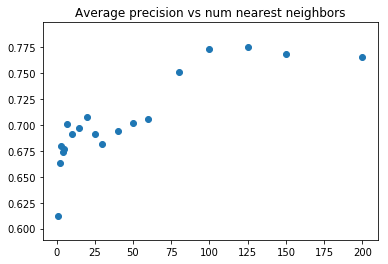

(125, [0.775905618281157, 0.7758482920644898, nan, 0.057272347535505426]) 


Train/val sets from: ('stylegan',)


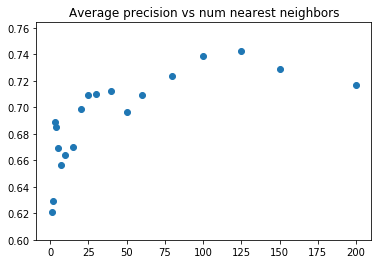

(125, [0.7276337389121809, 0.7427902315235686, nan, 0.07443397310653947]) 


Train/val sets from: ('began',)


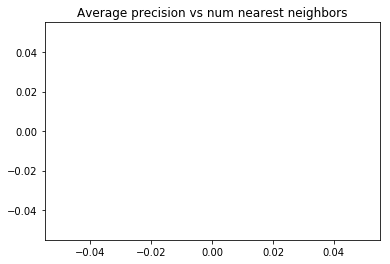

(1, [0.581815946734425, 0.6611505588428666, nan, 0.02]) 


Train/val sets from: ('wgan',)


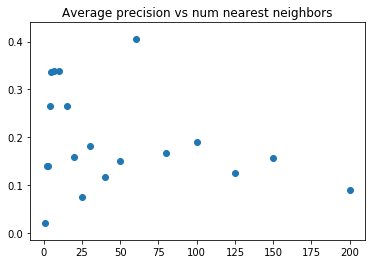

(60, [0.6211930695737521, 0.6848594696121673, nan, 0.4056372549019608]) 


Train/val sets from: ('progan', 'stylegan')


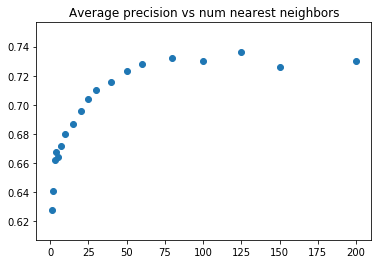

(125, [0.7187477021416615, 0.7536345921433484, nan, 0.07009012250635963]) 


Train/val sets from: ('progan', 'began')


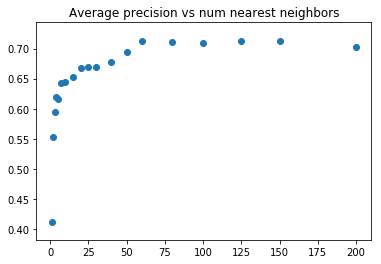

(60, [0.7470194193416515, 0.7558315158946275, nan, 0.0535457963089542]) 


Train/val sets from: ('progan', 'wgan')


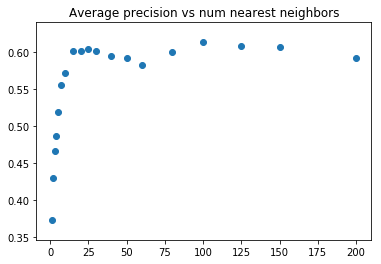

(100, [0.7069596761517531, 0.7672277118391481, nan, 0.060381778309409884]) 


Train/val sets from: ('stylegan', 'began')


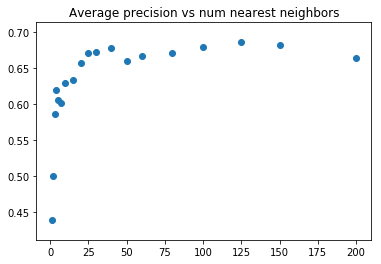

(125, [0.7534610198316369, 0.7322328502019622, nan, 0.07174326813753004]) 


Train/val sets from: ('stylegan', 'wgan')


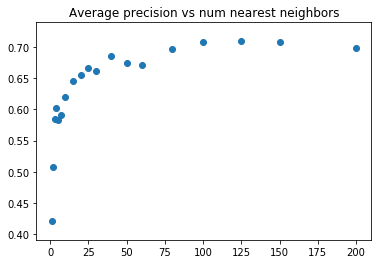

(125, [0.7239975227578487, 0.7909269236968705, nan, 0.08013271634692633]) 


Train/val sets from: ('began', 'wgan')


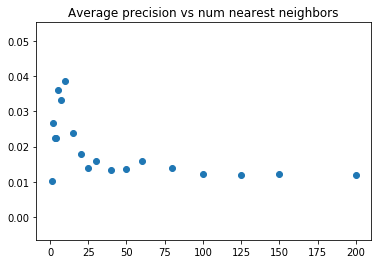

(10, [0.6123819816057109, 0.6695231449470482, nan, 0.3383333333333333]) 


Train/val sets from: ('progan', 'stylegan', 'began')


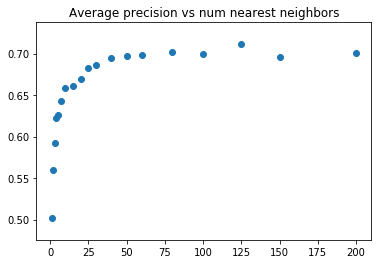

(125, [0.7435786724822548, 0.7414213092081265, nan, 0.07200254284941492]) 


Train/val sets from: ('progan', 'stylegan', 'wgan')


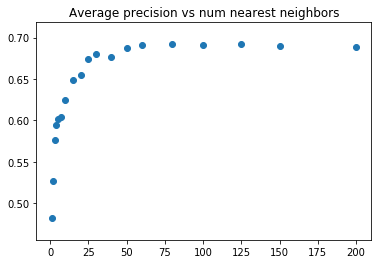

(125, [0.7123810032331699, 0.7774560014583616, nan, 0.07886871193322806]) 


Train/val sets from: ('progan', 'began', 'wgan')


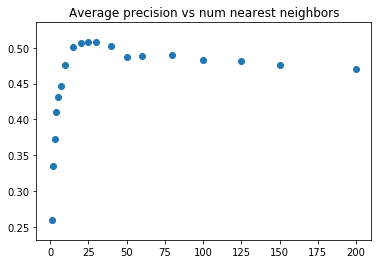

(25, [0.6970460619345982, 0.7615201376909685, nan, 0.053541699264590834]) 


Train/val sets from: ('stylegan', 'began', 'wgan')


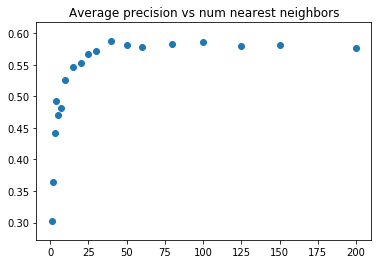

(40, [0.7253113147238488, 0.7480712197891793, nan, 0.07625517598343685]) 


Train/val sets from: ('progan', 'stylegan', 'began', 'wgan')


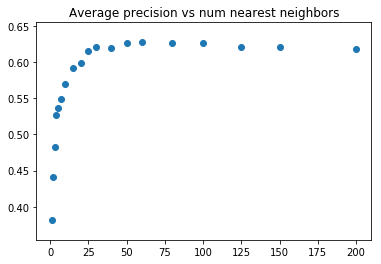

(60, [0.723596793772914, 0.751273037822694, nan, 0.07305801267875571]) 




In [69]:
all_best_ks = np.zeros((len(train_combos), len(gan_models)))
all_avg_precisions = np.zeros((len(train_combos), len(gan_models)))

for i, train_combo in enumerate(train_combos):
    print('Train/val sets from: {}'.format(train_combo))
    train_set = general_sum([train_files[x] for x in train_combo])
    val_set = general_sum([val_files[x] for x in train_combo])
    
    results = crossval_knn(train_set, val_set, test_sets, k_vals)
    best_k, avg_precisions = results
    best_ks[i,j] = best_k
    #print(avg_precisions)
    all_avg_precisions[i, :] = avg_precisions
        
    print(results, '\n\n')
    #for j, eval_model in enumerate(gan_models):
        #print('Test set from: {}'.format(eval_model))


In [39]:
import itertools
def general_sum(l):
    return reduce(lambda x,y: x+y, l)


#one_on_ones = [(m, train_files[m], val_files[m], val_files[m]) for m in gan_models]

#two_on_twos = [(m1 + ' & ' + m2, train_files[m1] + train_files[m2], val_files[m1] + val_files[m2],
#               val_files[m1] + val_files[m2]) for (m1,m2) in combinations(gan_models,2)]

#three_on_threes = [(m1 + ' & ' + m2 + ' & ' + m3, train_files[m1] + train_files[m2] + train_files[m3], 
#                    val_files[m1] + val_files[m2] + val_files[m3],
#               val_files[m1] + val_files[m2] + val_files[m3]) for (m1,m2,m3) in combinations(gan_models,3)]

all_on_all = [('All on all', general_sum([train_files[x] for x in gan_models]), 
               general_sum([val_files[x] for x in gan_models]),
               general_sum([val_files[x] for x in gan_models]))]

one_vs_ones = [('train and val on {}, test on {}'.format(t,v), train_files[t], val_files[t], val_files[v]) 
               for t,v in itertools.product(gan_models, repeat=2)]


combos_to_try = general_sum([all_on_all, one_vs_ones])

In [14]:
def list_minus(l1, l2):
    return [x for x in l1 if x not in l2]
list_minus(gan_models, ['progan', 'stylegan'])

['began', 'wgan']

In [23]:
two_combos = [(x,x) for x in combinations(gan_models,2)] + \
             [(x, list_minus(gan_models, x)) for x in combinations(gan_models,2)]

for c1,c2 in two_combos:
    print(c1,c2)

('progan', 'stylegan') ('progan', 'stylegan')
('progan', 'began') ('progan', 'began')
('progan', 'wgan') ('progan', 'wgan')
('stylegan', 'began') ('stylegan', 'began')
('stylegan', 'wgan') ('stylegan', 'wgan')
('began', 'wgan') ('began', 'wgan')
('progan', 'stylegan') ['began', 'wgan']
('progan', 'began') ['stylegan', 'wgan']
('progan', 'wgan') ['stylegan', 'began']
('stylegan', 'began') ['progan', 'wgan']
('stylegan', 'wgan') ['progan', 'began']
('began', 'wgan') ['progan', 'stylegan']


In [50]:
three_vs_one_combos = [(list_minus(gan_models, x), (x)) for x in gan_models]
three_vs_one_combos

[(['stylegan', 'began', 'wgan'], 'progan'),
 (['progan', 'began', 'wgan'], 'stylegan'),
 (['progan', 'stylegan', 'wgan'], 'began'),
 (['progan', 'stylegan', 'began'], 'wgan')]

['stylegan', 'began', 'wgan'] on progan


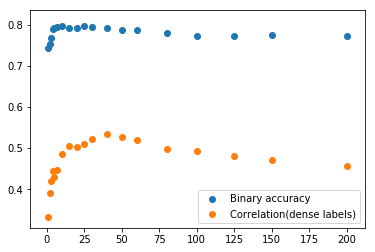

(23, 0.5751633986928104, SpearmanrResult(correlation=0.44034576635283307, pvalue=6.806590565083118e-11))



['progan', 'began', 'wgan'] on stylegan


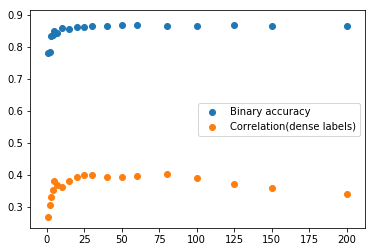

(29, 0.3422680412371134, SpearmanrResult(correlation=0.269535644480244, pvalue=0.00011357624686803555))



['progan', 'stylegan', 'wgan'] on began


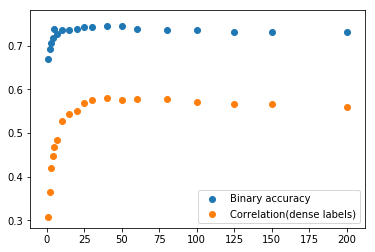

(23, 0.5725806451612904, SpearmanrResult(correlation=-0.01829493944691452, pvalue=0.7990999064447267))



['progan', 'stylegan', 'began'] on wgan


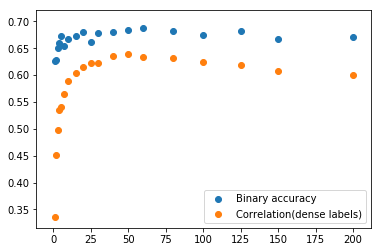

(25, 0.5914454277286135, SpearmanrResult(correlation=0.22570390586966496, pvalue=0.0013112942775400525))





In [55]:
three_vs_ones = [(str(c1) + ' on ' + str(c2),
        general_sum([train_files[x] for x in c1]),
        general_sum([val_files[x] for x in c1]),
        general_sum([val_files[x] for x in [c2]]) )
        for (c1,c2) in three_vs_one_combos]

for description, train_set, val_set, test_set in three_vs_ones:
    print(description)
    results = crossval_knn(train_set, val_set, test_set, k_vals)
    print(results)
    print()
    print()
    print()

In [43]:
# twos_on_self = [(m1 + ' & ' + m2, train_files[m1] + train_files[m2], val_files[m1] + val_files[m2],
#                val_files[m1] + val_files[m2]) for (m1,m2) in combinations(gan_models,2)]

# twos_on_others = [(m1 + ' & ' + m2, 
#                    train_files[m1] + train_files[m2], 
#                    val_files[m1] + val_files[m2],
#                    val_files[m1] + val_files[m2]) 
#                   for (m1,m2) in combinations(gan_models,2)]

twos = [(str(c1) + ' on ' + str(c2), 
        general_sum([train_files[x] for x in c1]),
        general_sum([val_files[x] for x in c1]),
        general_sum([val_files[x] for x in c2]) )
        for (c1,c2) in two_combos]

len(twos)

12

('progan', 'stylegan') on ('progan', 'stylegan')


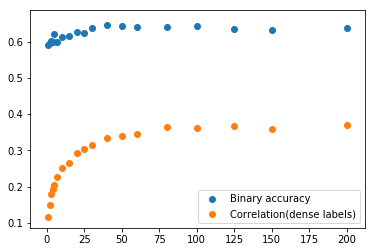

(37, 0.638432364096081, SpearmanrResult(correlation=0.36968144699053734, pvalue=2.12345361298973e-14))



('progan', 'began') on ('progan', 'began')


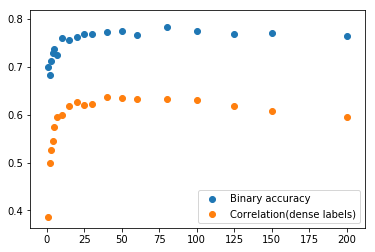

(23, 0.7635379061371841, SpearmanrResult(correlation=0.5943687891678133, pvalue=3.465328616690965e-39))



('progan', 'wgan') on ('progan', 'wgan')


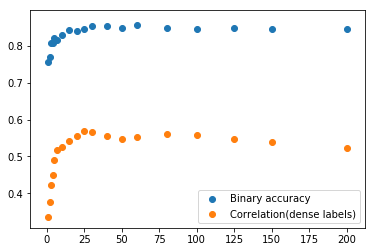

(19, 0.8445121951219512, SpearmanrResult(correlation=0.5238774281460791, pvalue=1.4215561102161923e-29))



('stylegan', 'began') on ('stylegan', 'began')


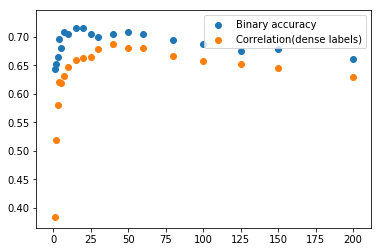

(23, 0.660300136425648, SpearmanrResult(correlation=0.6288557226324247, pvalue=5.552720031259187e-45))



('stylegan', 'wgan') on ('stylegan', 'wgan')


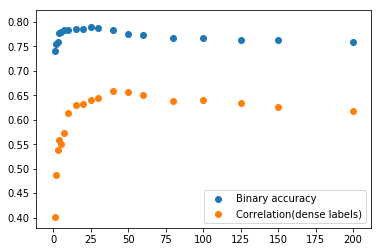

(23, 0.7592433361994841, SpearmanrResult(correlation=0.6172366167698831, pvalue=2.283565937160076e-43))



('began', 'wgan') on ('began', 'wgan')


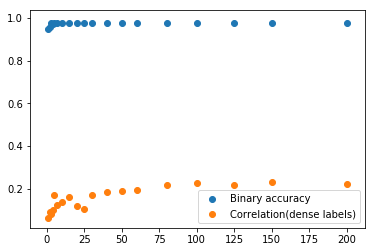

(35, 0.9751619870410367, SpearmanrResult(correlation=0.22298796298310788, pvalue=7.4675133319457185e-06))



('progan', 'stylegan') on ['began', 'wgan']


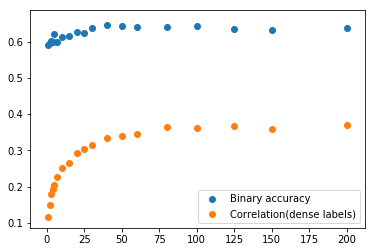

(37, 0.5226781857451404, SpearmanrResult(correlation=0.10731716608933764, pvalue=0.03276076584079924))



('progan', 'began') on ['stylegan', 'wgan']


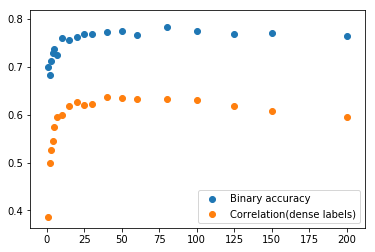

(23, 0.6801375752364575, SpearmanrResult(correlation=0.23107742081918245, pvalue=3.0054799828684628e-06))



('progan', 'wgan') on ['stylegan', 'began']


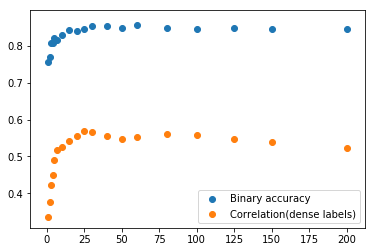

(19, 0.5702592087312415, SpearmanrResult(correlation=0.043807060962989815, pvalue=0.3846222589519904))



('stylegan', 'began') on ['progan', 'wgan']


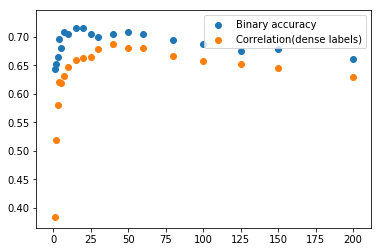

(23, 0.6270325203252033, SpearmanrResult(correlation=0.1865420053936356, pvalue=0.00017532401079496177))



('stylegan', 'wgan') on ['progan', 'began']


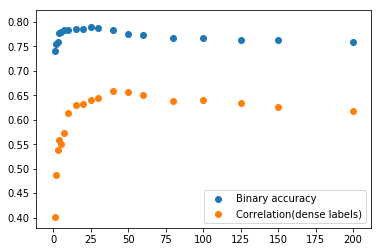

(23, 0.6299638989169675, SpearmanrResult(correlation=-0.007929955088760808, pvalue=0.8750023180478678))



('began', 'wgan') on ['progan', 'stylegan']


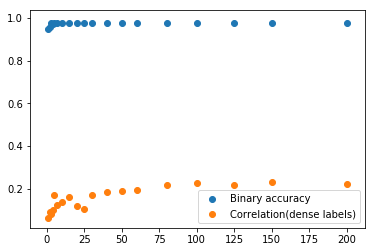

(35, 0.41466498103666244, SpearmanrResult(correlation=0.21060212020340469, pvalue=2.170561036484268e-05))





In [46]:
for description, train_set, val_set, test_set in twos:
    print(description)
    results = crossval_knn(train_set, val_set, test_set, k_vals)
    print(results)
    print()
    print()
    print()

All on all


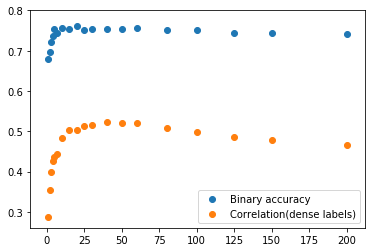

(23, 0.7414094350611532, SpearmanrResult(correlation=0.4672230194975822, pvalue=2.079435705222396e-44))



train and val on progan, test on progan


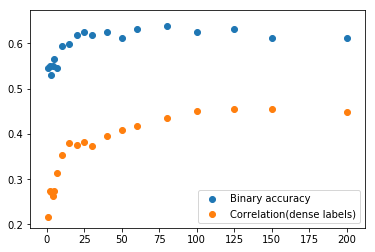

(35, 0.6111111111111112, SpearmanrResult(correlation=0.4473357163296084, pvalue=3.1201454028315684e-11))



train and val on progan, test on stylegan


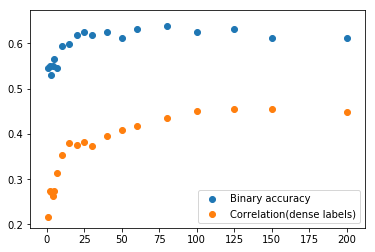

(35, 0.6061855670103092, SpearmanrResult(correlation=0.28695454586587843, pvalue=3.7938495707279845e-05))



train and val on progan, test on began


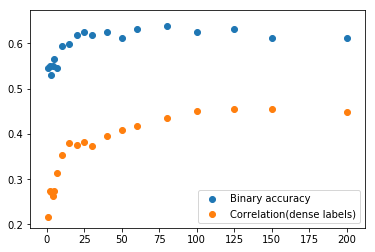

(35, 0.5241935483870968, SpearmanrResult(correlation=0.007231389802962448, pvalue=0.919873387863772))



train and val on progan, test on wgan


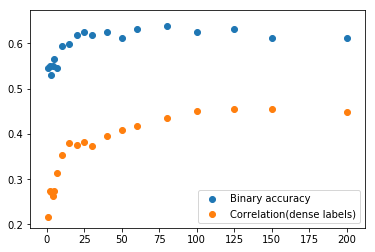

(35, 0.6533923303834809, SpearmanrResult(correlation=0.24193072101630314, pvalue=0.0005577150397428593))



train and val on stylegan, test on progan


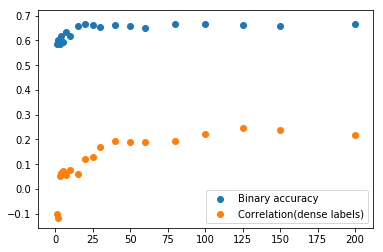

(6, 0.5718954248366013, SpearmanrResult(correlation=0.43914465634385985, pvalue=7.76903415746914e-11))



train and val on stylegan, test on stylegan


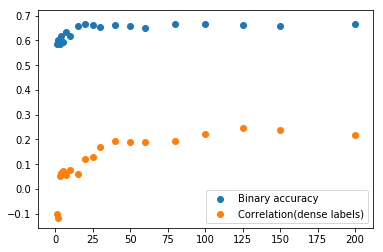

(6, 0.6659793814432989, SpearmanrResult(correlation=0.21896731798474087, pvalue=0.0018385285575396595))



train and val on stylegan, test on began


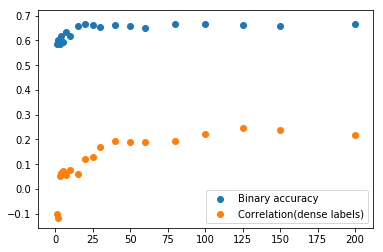

(6, 0.2056451612903226, SpearmanrResult(correlation=-0.06698799811110542, pvalue=0.350881083714947))



train and val on stylegan, test on wgan


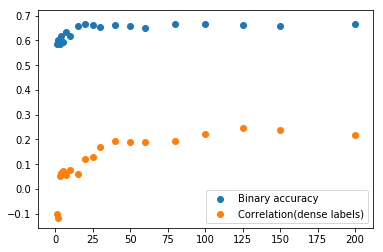

(6, 0.3997050147492625, SpearmanrResult(correlation=0.20957350127835267, pvalue=0.0028977080371857156))



train and val on began, test on progan


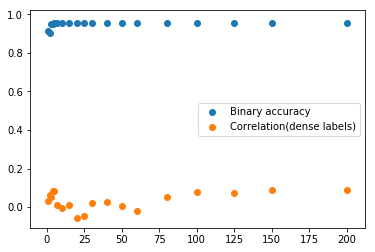

(26, 0.5294117647058824, SpearmanrResult(correlation=0.09514634410676333, pvalue=0.180186569834679))



train and val on began, test on stylegan


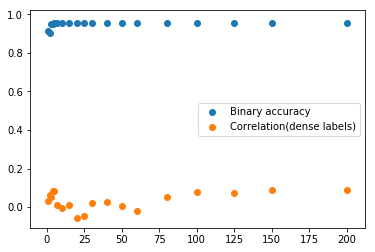

(26, 0.3422680412371134, SpearmanrResult(correlation=0.1783304653912349, pvalue=0.011522171461319274))



train and val on began, test on began


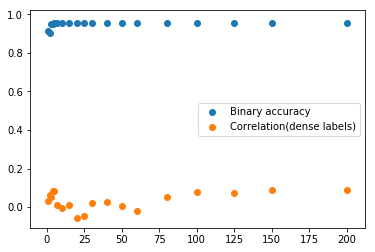

(26, 0.9556451612903226, SpearmanrResult(correlation=0.09039496583552656, pvalue=0.20766359469137569))



train and val on began, test on wgan


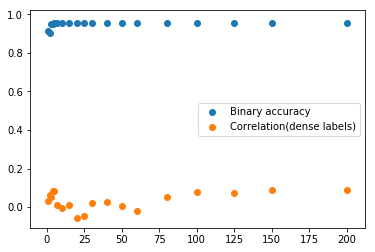

(26, 0.9823008849557522, SpearmanrResult(correlation=0.02583834673964194, pvalue=0.716470689011973))



train and val on wgan, test on progan


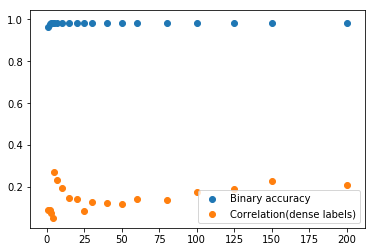

(8, 0.5294117647058824, SpearmanrResult(correlation=0.3391864857969908, pvalue=8.960795765124691e-07))



train and val on wgan, test on stylegan


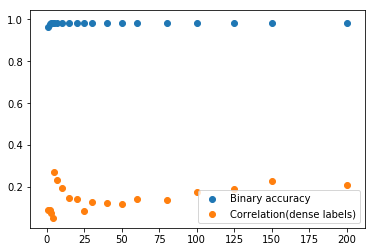

(8, 0.3422680412371134, SpearmanrResult(correlation=0.11598053457200404, pvalue=0.10195362011585384))



train and val on wgan, test on began


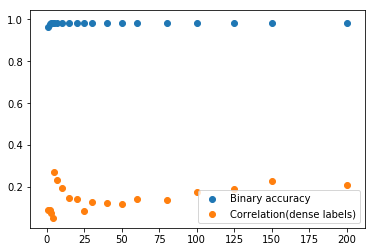

(8, 0.9556451612903226, SpearmanrResult(correlation=-0.017321522361714158, pvalue=0.8095797076787666))



train and val on wgan, test on wgan


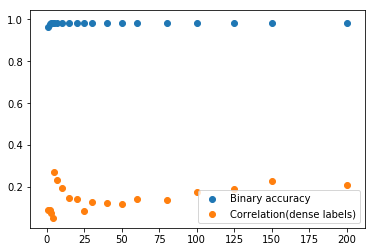

(8, 0.9823008849557522, SpearmanrResult(correlation=0.20689273244305928, pvalue=0.0032881009726070222))





In [253]:
for description, train_set, val_set, test_set in combos_to_try:
    print(description)
    results = crossval_knn(train_set, val_set, test_set, k_vals)
    print(results)
    print()
    print()
    print()

(4, 0.6045751633986928)

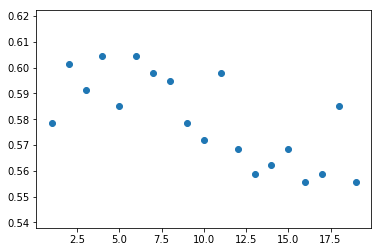

In [176]:
crossval_knn(stylegan_train_files, progan_val_files, range(1,20))

In [ ]:
progan_best_k, progan_accuracy = crossval_knn('progan')
print(progan_best_k, progan_accuracy)


77 0.6783505154639176


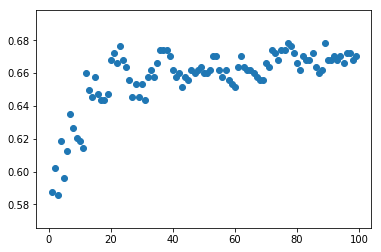

In [154]:
stylegan_best_k, stylegan_accuracy = crossval_knn('stylegan')
print(stylegan_best_k, stylegan_accuracy)


5 0.9556451612903226


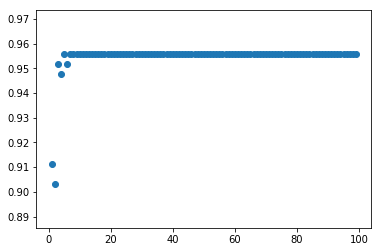

In [155]:
began_best_k, began_accuracy = crossval_knn('began')
print(began_best_k, began_accuracy)


3 0.9823008849557522


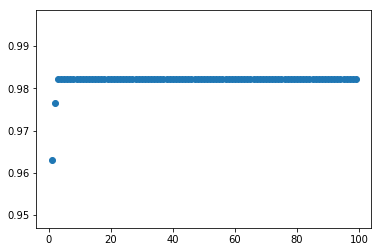

In [156]:
wgan_best_k, wgan_accuracy = crossval_knn('wgan')
print(wgan_best_k, wgan_accuracy)

Todo:
#Functionize everything, include crossval+test
#Run numbers on dense labels
#Abstract out dataset
Run on every combo of dataset

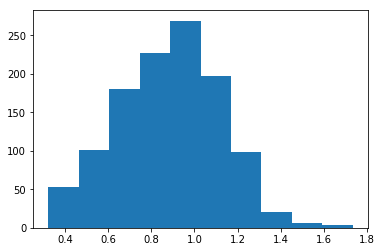

In [163]:
nvidia_scores = {}
with open('/Users/alexkolchinski/Downloads/nvidia_realism_scores.csv') as f:
    reader = csv.reader(f)
    for row in islice(reader, 1, None):
        nvidia_scores[row[0]] = float(row[1])
    #lines = f.readlines()
    #print(lines)
    
#for k,v in nvidia_scores.items():
    #print(k,v, dense_labels[k] if k in dense_labels else None)
    
    
plt.hist(nvidia_scores.values())
plt.show()

worst ones:


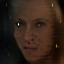

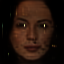

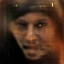

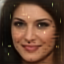

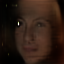

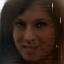

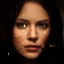

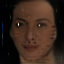

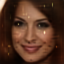

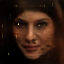

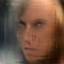

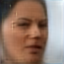

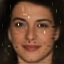

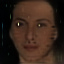

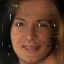



best ones:


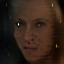

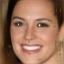

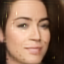

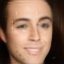

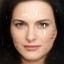

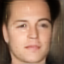

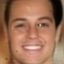

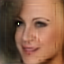

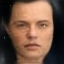

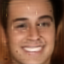

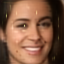

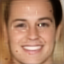

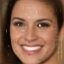

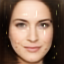

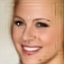

In [199]:
worst_to_best_began = sorted([(k,v) for k,v in nvidia_scores.items() if 'BEGAN' in k], key=lambda x: x[1])

print("worst ones:")
for i in range(15):
    display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + worst_to_best_began[i][0]))


print("\n\nbest ones:")
for i in range(15):
    display(Image(filename='../imgs_by_label/began_labeled/began_labeled_imgs/' + worst_to_best_began[-i][0]))
